In [40]:
import os
import pickle
import numpy as np
import datetime
import json
from multiprocessing import Process
from multiprocess import Process

import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16, MobileNetV2, MobileNetV3Small

from models import *
from utils import regression_stats
from img_utils import data_to_df, preprocess_images, set_gpu, set_cpu

import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2

In [41]:
from img_utils import data_to_df
#try reloading the module
IMAGE_WIDTH: int = 224
IMAGE_HEIGHT: int = 224

IMG_WIDTH_448: int = 448
IMG_HEIGHT_448: int = 448


# Load Data
train_1_path: str = "output/train/train_1"
train_2_path: str = "output/train/train_2"
valid_path: str = "output/valid"
test_path: str = "output/test"

# train_1_path: str = "output/train/train_1"
# train_2_path: str = "output/train/train_2"
# valid_path: str = "output/valid"
# test_path: str = "output/test"

train1_df, train2_df, valid_df, test_df = data_to_df(
    [train_1_path, train_2_path, valid_path, test_path], preprocess=True, rm_outliers=True
)

display(train1_df.head())
# Print the lenghts of the datasets
print("Length of datasets:")
print(f"Train 1: {len(train1_df)}")
print(f"Train 2: {len(train2_df)}")
print(f"Valid: {len(valid_df)}")
print(f"Test: {len(test_df)}")

# TODO: Would be better with this format
# train_images: np.array = preprocess_images(
#     train1_df["image_floorplan"], IMAGE_WIDTH, IMAGE_HEIGHT, True, False, False
# )


#### Train Set 1 ####
train1_features = train1_df.drop(columns=["image_floorplan", "price"])
train1_images: np.array = preprocess_images(
    train1_df, "image_floorplan", IMAGE_WIDTH, IMAGE_HEIGHT, True, False, False
)
train1_images_448: np.array = preprocess_images(    
    train1_df, "image_floorplan", IMG_WIDTH_448, IMG_HEIGHT_448, True, False, False
)
train1_prices: np.array = train1_df["price"].values


#### Train Set 2 ####
train2_features = train2_df.drop(columns=["image_floorplan", "price"])
train2_images: np.array = preprocess_images(
    train2_df, "image_floorplan", IMAGE_WIDTH, IMAGE_HEIGHT, True, False, False
)
train2_images_448: np.array = preprocess_images(
    train2_df, "image_floorplan", IMG_WIDTH_448, IMG_HEIGHT_448, True, False, False
)
train2_prices: np.array = train2_df["price"].values


#### Validation Set ####
valid_features = valid_df.drop(columns=["image_floorplan", "price"])
valid_images: np.array = preprocess_images(
    valid_df, "image_floorplan", IMAGE_WIDTH, IMAGE_HEIGHT, True, False, False
)
valid_images_448: np.array = preprocess_images(
    valid_df, "image_floorplan", IMG_WIDTH_448, IMG_HEIGHT_448, True, False, False
)
valid_prices: np.array = valid_df["price"].values


#### Test Set ####
test_features = test_df.drop(columns=["image_floorplan", "price"])
test_images: np.array = preprocess_images(
    test_df, "image_floorplan", IMAGE_WIDTH, IMAGE_HEIGHT, True, False, False
)
test_images_448: np.array = preprocess_images(
    test_df, "image_floorplan", IMG_WIDTH_448, IMG_HEIGHT_448, True, False, False
)

test_prices: np.array = test_df["price"].values

Preprocessing: 100%|██████████| 4/4 [00:00<00:00, 18.39it/s]


Removing outliers...
Datapoints before: 829


Removing outliers: 100%|██████████| 4/4 [00:00<00:00, 106.04it/s]


Datapoints after: 813


,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,postal_avg_sqm_price,lat,lng,image_floorplan
0,64,0,1750000,40,0,2.0,1944.0,1944.0,4,32687.50,55.736966,12.513117,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,37,0,8500000,138,0,4.0,2005.0,2005.0,4,55737.75,55.698085,12.594470,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,40,0,5995000,139,0,5.0,1935.0,2009.0,4,44946.75,55.654361,12.601795,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4,36,0,4495000,76,0,3.0,1932.0,1932.0,4,50502.00,55.691502,12.529448,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
5,62,0,2995000,70,0,3.0,1963.0,1963.0,5,36072.25,55.812616,12.469592,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


Length of datasets:
Train 1: 284
Train 2: 286
Valid: 83
Test: 160


In [42]:
def save_expected_predicted(test_prices, test_predictions, img_dir):
        #Set X and Y axis to [0, 9.000.000]
    #plt.xlim(0, 9999999)
    #plt.ylim(0, 9999999)
    plt.scatter(test_prices, test_predictions)
    plt.xlabel("Expected Price")
    plt.ylabel("Predicted Price")
    plt.title("Expected vs Predicted Price")
    try: 
        plt.plot([min(test_prices), max(test_prices)], [min(test_prices), max(test_prices)], color='red')
    except:
        pass
    plt.savefig(f"{img_dir}/expected_vs_predicted.png")
    plt.close()

def save_residuals(test_prices, test_predictions, img_dir):
    residuals = test_prices - test_predictions.reshape(-1)
    plt.scatter(test_predictions, residuals)
    try:
        plt.hlines(y=0, xmin=test_prices.min(), xmax=test_prices.max(), colors="r")
    except:
        pass
    plt.xlabel("Expected Price")
    plt.ylabel("Residuals")
    plt.title("Residuals")
    plt.savefig(f"{img_dir}/residuals.png")
    plt.close()

def get_saliency_map(model, image):
    image = np.expand_dims(image, axis=0)
    image = image / 255.0
    image = image.astype(np.float32)
    image = tf.convert_to_tensor(image)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
    gradients = tape.gradient(prediction, image)
    gradients = tf.squeeze(gradients)
    gradients = tf.reduce_max(gradients, axis=-1)
    gradients = gradients.numpy()
    gradients = (gradients - np.min(gradients)) / (np.max(gradients) - np.min(gradients))
    return gradients

def save_worst_best_predictions(model, test_predictions, test_prices, test_images, img_dir):
    residuals = test_prices - test_predictions.reshape(-1)
    distances = np.abs(test_prices - test_predictions.reshape(-1))
    worst_predictions = np.argsort(distances)[-8:]
    best_predictions = np.argsort(distances)[:8]
    test_images = np.array(test_images)
    for i, idx in enumerate(worst_predictions):
        image = test_images[idx]
        price = test_prices[idx]
        prediction = test_predictions[idx]
        residual = residuals[idx]
        plt.imshow(image)
        textstr = '\n'.join((
            f"Price: {price}",
            f"Predicted Price: {prediction}",
            f"Residual: {residual}"
        ))
        plt.text(0.01, 0.99, textstr, fontsize=10, transform=plt.gcf().transFigure, verticalalignment='top')
        plt.axis("off")
        plt.savefig(f"{img_dir}/worst_{i}.png")
        plt.close()
        
        saliency_map = get_saliency_map(model, image)
        plt.imshow(saliency_map, cmap="hot")
        plt.axis("off")
        plt.savefig(f"{img_dir}/worst_saliency_map_{i}.png")
        plt.close()
        
    for i, idx in enumerate(best_predictions):
        image = test_images[idx]
        price = test_prices[idx]
        prediction = test_predictions[idx]
        residual = residuals[idx]
        plt.imshow(image)
        textstr = '\n'.join((
            f"Price: {price}",
            f"Predicted Price: {prediction}",
            f"Residual: {residual}"
        ))
        plt.text(0.01, 0.99, textstr, fontsize=10, transform=plt.gcf().transFigure, verticalalignment='top')
        plt.axis("off")
        plt.savefig(f"{img_dir}/best_{i}.png")
        plt.close()
        saliency_map = get_saliency_map(model, image)
        plt.imshow(saliency_map, cmap="hot")
        plt.axis("off")
        plt.savefig(f"{img_dir}/best_saliency_map_{i}.png")
        plt.close()

def save_features_importance(feature_importance, img_dir):
    #sort the feature_importance dict by value
    feature_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}
    #add percentages to the bars
    plt.bar(feature_importance.keys(), feature_importance.values())
    #plt.bar_label = feature_importance.values()
    plt.title('Feature Importance')
    #Remove y-labels
    plt.ylabel('')
    plt.xticks(rotation=90)
    #Zoom out so that text is visible 
    plt.subplots_adjust(bottom=0.4)
    plt.savefig(f"{img_dir}/feature_importance.png")
    plt.close()

def save_worst_best(test_predictions, test_prices, test_features, model_dir):
    #Find the best predictions, and worst predictions. 
    #Save them in two dataframes. Save a latex of the dataframe in a txt-file 
    residuals = test_prices - test_predictions.reshape(-1)
    distances = np.abs(test_prices - test_predictions.reshape(-1))
    worst_predictions = np.argsort(distances)[-8:]
    best_predictions = np.argsort(distances)[:8]
    
    test_features_ = pd.DataFrame(test_features).copy()
    test_features_["Price"] = test_prices
    test_features_["Predicted Price"] = test_predictions
    test_features_["Residual"] = residuals
    test_features_['Absolute Distances'] = distances
    test_features_ = test_features_.sort_values(by="Absolute Distances", ascending=False)
    worst_df = test_features_.head(8)
    best_df = test_features_.tail(8)
    #save worst and best as latex in txt-file 
    worst_df.to_latex(f"{model_dir}/worst_predictions.txt")
    best_df.to_latex(f"{model_dir}/best_predictions.txt")
    
   
def save_reconstuctions(AE, test_predictions, test_prices, test_images, model_dir):
    n = 10
    reconstruction_errors = AE.calculate_ssim(test_images)
    best5 = np.argsort(reconstruction_errors)[:n]
    worst5 = np.argsort(reconstruction_errors)[::-1][:n]
    print(best5)
    print(worst5)
    for i in range(n):
        idx = best5[i]
        image = test_images[idx]
        encoded_img = AE.encode(np.expand_dims(image, axis=0))
        decoded_img = AE.decode(encoded_img)
        encoded_img = np.squeeze(encoded_img)
        decoded_img = np.squeeze(decoded_img)
        #Turn decoded_img into intergers
        decoded_img = decoded_img.astype(int)
        fix, ax = plt.subplots(1, 2, figsize=(15, 5))
        ax[0].imshow(image)
        ax[0].set_title("Original Image")
        ax[1].imshow(decoded_img)
        ax[1].set_title("Reconstructed Image")
        #Set overall title as the price vs. the predicted price
        price = test_prices[idx]
        predicted_price = test_predictions[idx]
        textstr = '\n'.join((
            f"Price: {price}",
            f"Predicted Price: {predicted_price}"
        ))
        plt.text(0.01, 0.99, textstr, fontsize=10, transform=plt.gcf().transFigure, verticalalignment='top')
        plt.savefig(f"{model_dir}/best_reconstruction_{i}.png")
        plt.close()
        

    for i in range(n):
        idx = worst5[i]
        image = test_images[idx]
        encoded_img = AE.encode(np.expand_dims(image, axis=0))
        decoded_img = AE.decode(encoded_img)
        encoded_img = np.squeeze(encoded_img)
        decoded_img = np.squeeze(decoded_img)
        #Turn decoded_img into intergers
        decoded_img = decoded_img.astype(int)
        fix, ax = plt.subplots(1, 2, figsize=(15, 5))
        ax[0].imshow(image)
        ax[0].set_title("Original Image")
        ax[1].imshow(decoded_img)
        ax[1].set_title("Reconstructed Image")
        price = test_prices[idx]
        predicted_price = test_predictions[idx]
        textstr = '\n'.join((
            f"Price: {price}",
            f"Predicted Price: {predicted_price}"
        ))
        plt.text(0.01, 0.99, textstr, fontsize=10, transform=plt.gcf().transFigure, verticalalignment='top')
        plt.savefig(f"{model_dir}/worst_reconstruction_{i}.png")
        plt.close()

def save_reconstuctions(AE, test_predictions, test_prices, test_images, model_dir):
    n = 10
    reconstruction_errors = AE.calculate_ssim(test_images)
    #best5 = np.argsort(reconstruction_errors)[:n]
    #worst5 = np.argsort(reconstruction_errors)[::-1][:n]
    residuals = test_prices - test_predictions.reshape(-1)
    distances = np.abs(test_prices - test_predictions.reshape(-1))
    worst5 = np.argsort(distances)[-n:]
    best5 = np.argsort(distances)[:n]
    for i in range(n):
        idx = best5[i]
        image = test_images[idx]
        encoded_img = AE.encode(np.expand_dims(image, axis=0))
        decoded_img = AE.decode(encoded_img)
        encoded_img = np.squeeze(encoded_img)
        decoded_img = np.squeeze(decoded_img)
        #Turn decoded_img into intergers
        decoded_img = decoded_img.astype(int)
        fix, ax = plt.subplots(1, 2, figsize=(15, 5))
        ax[0].imshow(image)
        ax[0].set_title("Original Image")
        ax[1].imshow(decoded_img)
        ax[1].set_title("Reconstructed Image")
        #Set overall title as the price vs. the predicted price
        price = test_prices[idx]
        predicted_price = test_predictions[idx]
        textstr = '\n'.join((
            f"Price: {price}",
            f"Predicted Price: {predicted_price}"
        ))
        plt.text(0.01, 0.99, textstr, fontsize=10, transform=plt.gcf().transFigure, verticalalignment='top')
        plt.savefig(f"{model_dir}/best_reconstruction_{i}.png")
        plt.close()
        

    for i in range(n):
        idx = worst5[i]
        image = test_images[idx]
        encoded_img = AE.encode(np.expand_dims(image, axis=0))
        decoded_img = AE.decode(encoded_img)
        encoded_img = np.squeeze(encoded_img)
        decoded_img = np.squeeze(decoded_img)
        #Turn decoded_img into intergers
        decoded_img = decoded_img.astype(int)
        fix, ax = plt.subplots(1, 2, figsize=(15, 5))
        ax[0].imshow(image)
        ax[0].set_title("Original Image")
        ax[1].imshow(decoded_img)
        ax[1].set_title("Reconstructed Image")
        price = test_prices[idx]
        predicted_price = test_predictions[idx]
        textstr = '\n'.join((
            f"Price: {price}",
            f"Predicted Price: {predicted_price}"
        ))
        plt.text(0.01, 0.99, textstr, fontsize=10, transform=plt.gcf().transFigure, verticalalignment='top')
        plt.savefig(f"{model_dir}/worst_reconstruction_{i}.png")
        plt.close()


def save_model_and_evaluate(
    model: object,
    fit_history: object,
    test_images: np.array,
    test_features: np.array,
    test_prices: np.array,
    model_dir: str,
    model_type:str
):
    if model_type == 'RF':
        print("Saving Model...")
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        with open(f"{model_dir}/model", "wb") as file_pi:
            pickle.dump(model, file_pi)
        test_predictions = model.predict(test_features)
    
    if model_type == "CNN":
        # Save Model
        print("Saving Model...")
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model.save(f"{model_dir}/model")
        # Save Training History
        with open(f"{model_dir}/history", "wb") as file_pi:
            pickle.dump(fit_history.history, file_pi)
        test_predictions = model.predict(test_images)
        #Save Model Architecture
        #plot_model(model, to_file=f"{model_dir}/model_architecture.png", show_shapes=True, show_layer_names=True, show_dtype=True, rankdir="TB", expand_nested=False, dpi=96)
        img = plot_model(model, to_file=f"{model_dir}/architecture.png", show_shapes=True, show_layer_names=True, show_dtype=True, rankdir="TB", expand_nested=False, dpi=96)


    if model_type == 'CNN_RF' or model_type == 'CNN_AE_RF':
        print("Saving Model...")
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        with open(f"{model_dir}/model", "wb") as file_pi:
            pickle.dump(model, file_pi)
        test_predictions = model.predict(test_images, test_features)
        

    # Evaluate Model
    print("Evaluating Model...")
    r2, mae, percentage_error, mse = regression_stats(test_prices, test_predictions)

    try:
        feature_importance = model.feature_importances_
        if model_type == "RF":
            feature_importance = dict(zip(test_features.columns, feature_importance))
    except AttributeError:
        print("Cant find feature_importance")
        feature_importance = None

    # Load existing evaluation data
    evaluation_file_path = f"{model_dir}/evaluation.json"
    evaluation_data = {}
    if os.path.exists(evaluation_file_path):
        with open(evaluation_file_path, "r") as json_file:
            evaluation_data = json.load(json_file)

    # Add new evaluation data
    new_evaluation = {
        "Timestamp": str(datetime.datetime.now()),
        "R2": r2,
        "MAE": mae,
        "Percentage Error": percentage_error,
        "MSE": mse,
        "Feature Importances": (feature_importance),
    }
    evaluation_data[len(evaluation_data)] = new_evaluation

    # Save updated evaluation data
    with open(evaluation_file_path, "w") as json_file:
        json.dump(evaluation_data, json_file, indent=4)

    # Compute median evaluation values from all instances
    r2_values = [evaluation_data[key]["R2"] for key in evaluation_data]
    mae_values = [evaluation_data[key]["MAE"] for key in evaluation_data]
    percentage_error_values = [
        evaluation_data[key]["Percentage Error"] for key in evaluation_data
    ]
    mse_values = [evaluation_data[key]["MSE"] for key in evaluation_data]

    median_evaluation_data = {
        "R2": np.median(r2_values),
        "MAE": np.median(mae_values),
        "Percentage Error": np.median(percentage_error_values),
        "MSE": np.median(mse_values),
    }

    with open(f"{model_dir}/median_evaluation.json", "w") as json_file:
        json.dump(median_evaluation_data, json_file, indent=4)

    print("\nModel Evaluation:")
    print(new_evaluation)
    print("\nMedian Evaluation:")
    print(median_evaluation_data)
    print("Feauter Importance...")
    print(feature_importance)

    # Images (Create or open existing folder)
    if not os.path.exists(f"{model_dir}/images"):
        os.makedirs(f"{model_dir}/images")
    img_dir = f"{model_dir}/images"
    
    save_expected_predicted(test_prices, test_predictions, img_dir)
    save_residuals(test_prices, test_predictions, img_dir)
    
    if model_type == 'CNN':
        print("\nSaving Best and Worst Image Predictions")
        save_worst_best_predictions(model, test_predictions, test_prices, test_images, img_dir)
    
    if model_type != 'CNN': 
        print("\nSaving Feature Importance")
        save_features_importance(feature_importance, img_dir)

    if model_type == 'CNN_AE_RF':
        print("\nSaving Reconstructions")
        save_reconstuctions(model.autoEncoder_, test_predictions, test_prices, test_images, img_dir)

    save_worst_best(test_predictions, test_prices, test_features, model_dir)
    print("\nDone!")


def train_save_model(
    model_func: object,
    args: tuple,
    test_images: np.array,
    test_features: np.array,
    test_prices: np.array,
    model_dir: str,
    use_gpu: bool,
    model_type:str
):
    if use_gpu:
        set_gpu()
    else:
        set_cpu()

    if model_type == "CNN":
        model, fit_history = model_func(*args)
    if model_type == 'RF':
        model = model_func(*args)
        fit_history = None
    if model_type == 'CNN_RF' or model_type == 'CNN_AE_RF':
        model = model_func(*args)
        fit_history = None
    save_model_and_evaluate(model, fit_history, test_images, test_features, test_prices, model_dir, model_type)


def train_save_models(
    model_func: object,
    args: tuple,
    test_images: np.array,
    test_prices: np.array,
    model_dir: str,
    use_gpu: bool,
):
    if use_gpu:
        set_gpu()
    else:
        set_cpu()

    models, fit_histories = model_func(*args)
    for model_idx, (model, fit_history) in enumerate(zip(models, fit_histories)):
        save_model_and_evaluate(
            model, fit_history, test_images, test_prices, f"{model_dir}_{model_idx}"
        )

# Running on CPU

In [43]:
MODELS_PATH: str = "./models"
USE_GPU: bool = False

In [84]:
train2_features = train2_features[['postal_code', 'type', 'size', 'basement_size', 'rooms', 'year_built','year_rebuilt', 'energy_label', 'postal_avg_sqm_price', 'lat', 'lng' ]]

### Naive Guess

In [85]:
mean = test_prices.mean()
mean_Guess = np.full(len(test_prices), mean)
r2, mae, percentage_error, mse = regression_stats(test_prices, mean_Guess)
print(f"Mean Guess R2: {r2}, MAE: {mae}, Percentage Error: {percentage_error}, MSE: {mse}")


Mean Guess R2: 0.0, MAE: 1735519.21875, Percentage Error: 51.359256053020786, MSE: 4822871623085.9375


### Lasso Regression

In [86]:
from models import Lasso_
lasso_model = Lasso_(train2_features, train2_prices)
predictions = lasso_model.predict(test_features)
r2, mae, percentage_error, mse = regression_stats(test_prices, predictions)
print(f"Lasso R2: {r2}, MAE: {mae}, Percentage Error: {percentage_error}, MSE: {mse}")

Lasso R2: 0.7748060360794036, MAE: 722675.3010574252, Percentage Error: 19.005414937968073, MSE: 1086081578282.8832


### RF

In [82]:
from models import RF
TYPE = "RF"
MODEL_NAME: str = "RF"
FUNCTION: object = RF
ARGS: tuple = (
    train2_features,
    train2_prices,
)
for i in range(10):
    train_save_model(FUNCTION, ARGS, test_images, test_features, test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU
Saving Model...
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 14:25:34.211052', 'R2': 0.8132795001078803, 'MAE': 636993.1875, 'Percentage Error': 14.843292596179808, 'MSE': 900529000378.125, 'Feature Importances': {'postal_code': 0.06814842648710288, 'type': 0.0, 'size': 0.6508014320289626, 'basement_size': 0.0, 'rooms': 0.00849383156803667, 'year_built': 0.03364348661701729, 'year_rebuilt': 0.05323962858913134, 'energy_label': 0.011810161816716453, 'postal_avg_sqm_price': 0.12483953588065484, 'lat': 0.01947357892950805, 'lng': 0.02954991808286986}}

Median Evaluation:
{'R2': 0.8089473545247409, 'MAE': 644189.3125, 'Percentage Error': 15.029167119871515, 'MSE': 921422382378.125}
Feauter Importance...
{'postal_code': 0.06814842648710288, 'type': 0.0, 'size': 0.6508014320289626, 'basement_size': 0.0, 'rooms': 0.00849383156803667, 'year_built': 0.03364348661701729, 'year_rebuilt': 0.05323962858913134, 'energy_label': 0.011810161816716453, 'postal_avg_sqm_pri

### CNN

In [ ]:
from models import CNN_model1
from keras.applications import MobileNetV3Large

TYPE = 'CNN'
MODEL_NAME: str = "MobileNetV3_Large_1"
FUNCTION: object = CNN_model1
ARGS: tuple = (
    MobileNetV3Large,
    train1_images,
    train1_prices,
    valid_images,
    valid_prices,
    [
    Flatten(),
    Dense(512, activation="relu", kernel_regularizer=regularizers.l1(0.2)),
    # BatchNormalization(),
    layers.Dropout(0.2),
    Dense(256, activation="relu", kernel_regularizer=regularizers.l1(0.2)),
    layers.Dropout(0.2),
    Dense(128, activation="relu", kernel_regularizer=regularizers.l1(0.2)),
    layers.Dropout(0.1),
    Dense(64, activation="relu"),
    Dense(1, activation="linear"),
    ],
)
#train_save_model(FUNCTION, ARGS, test_images, test_features, test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU
Compiling Model
Fitting Model
Epoch 1/100
9/9 [==============================] - 56s 2s/step - loss: 3830072.2500 - mean_absolute_error: 3814672.7500 - val_loss: 4307765.0000 - val_mean_absolute_error: 4302022.0000
Epoch 2/100
9/9 [==============================] - 13s 1s/step - loss: 3818524.0000 - mean_absolute_error: 3812578.2500 - val_loss: 4300476.0000 - val_mean_absolute_error: 4295219.5000
Epoch 3/100
9/9 [==============================] - 12s 1s/step - loss: 3796468.7500 - mean_absolute_error: 3791127.5000 - val_loss: 4245161.0000 - val_mean_absolute_error: 4238672.5000
Epoch 4/100
9/9 [==============================] - 13s 1s/step - loss: 3663740.5000 - mean_absolute_error: 3655459.5000 - val_loss: 3942680.0000 - val_mean_absolute_error: 3931179.5000
Epoch 5/100
9/9 [==============================] - 13s 1s/step - loss: 3048435.5000 - mean_absolute_error: 3033076.5000 - val_loss: 2761275.0000 - val_mean_absolute_error: 2740058.5000
Epoch 6/100
9/9 [================

INFO:tensorflow:Assets written to: ./models/MobileNetV3_Large_1/model/assets


5/5 [==============================] - 17s 931ms/step
Evaluating Model...
Cant find feature_importance

Model Evaluation:
{'Timestamp': '2024-05-02 10:58:37.598544', 'R2': 0.36634960560336016, 'MAE': 1321069.37890625, 'Percentage Error': 55.96587296383744, 'MSE': 3056014506092.7666, 'Feature Importances': None}

Median Evaluation:
{'R2': 0.36634960560336016, 'MAE': 1321069.37890625, 'Percentage Error': 55.96587296383744, 'MSE': 3056014506092.7666}
Feauter Importance...
None

Saving Best and Worst Image Predictions

Done!


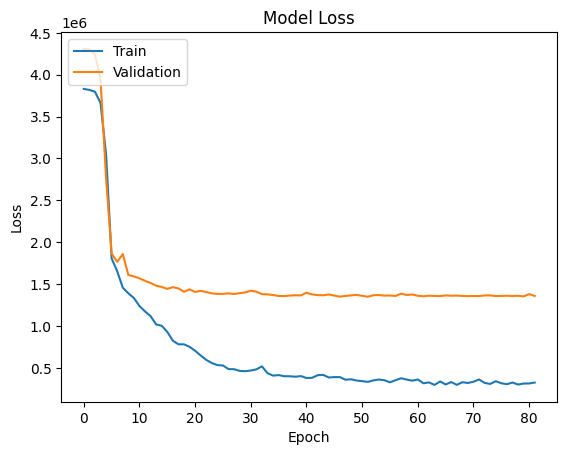

In [ ]:
#load the fit-history 
with open(f"{MODELS_PATH}/MobileNetV3_Large_1/history", "rb") as file_pi:
    history = pickle.load(file_pi)

#plot the history
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#Add legend
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(f"{MODELS_PATH}/MobileNetV3_Large/loss.png")
plt.show()
plt.close()


### CNN RF

#### MobileNetV3Large + Random Forrest

In [73]:
MobileNet_CNN = keras.models.load_model(f"{MODELS_PATH}/MobileNetV3_Large_1/model")
#MobileNet_CNN =  keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")

In [81]:
from models import CNN_RF_model
TYPE = 'CNN_RF'
MODEL_NAME: str = "MobileNetV3_Large_RF_1"
FUNCTION: object = CNN_RF_model
ARGS: tuple = (
    MobileNet_CNN, # keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
    train2_images,
    train2_features,
    train2_prices,
)
for i in range(10):
    train_save_model(FUNCTION, ARGS, test_images, test_features,  test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU
9/9 [==============================] - 8s 936ms/step
Saving Model...
5/5 [==============================] - 5s 937ms/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 14:19:01.895835', 'R2': 0.817811688777333, 'MAE': 639530.125, 'Percentage Error': 15.353762324169459, 'MSE': 878670836253.75, 'Feature Importances': {'image_predictions': 0.02692777596578086, 'postal_code': 0.07059495862881453, 'type': 0.0, 'size': 0.6486507166713145, 'basement_size': 0.0, 'rooms': 0.009175427202953348, 'year_built': 0.034210252930964594, 'year_rebuilt': 0.04447188999376324, 'energy_label': 0.01079319457535719, 'postal_avg_sqm_price': 0.11251680007812587, 'lat': 0.01849324145945681, 'lng': 0.02416574249346909}}

Median Evaluation:
{'R2': 0.8167331440759821, 'MAE': 644872.6875, 'Percentage Error': 15.384344816548316, 'MSE': 883872518888.125}
Feauter Importance...
{'image_predictions': 0.02692777596578086, 'postal_code': 0.07059495862881453, 'type': 0.0, 'size': 0.64865071667

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 8s 922ms/step
Saving Model...
5/5 [==============================] - 5s 954ms/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 14:19:19.959075', 'R2': 0.8241007556801427, 'MAE': 635521.375, 'Percentage Error': 15.076718018878205, 'MSE': 848339473952.5, 'Feature Importances': {'image_predictions': 0.028249367981720997, 'postal_code': 0.063859321043778, 'type': 0.0, 'size': 0.6393128860697473, 'basement_size': 0.0, 'rooms': 0.007981615094910403, 'year_built': 0.04197085085221907, 'year_rebuilt': 0.046707161035423855, 'energy_label': 0.009918180419150617, 'postal_avg_sqm_price': 0.12275268026367993, 'lat': 0.014674919579166324, 'lng': 0.024573017660203554}}

Median Evaluation:
{'R2': 0.8167331440759821, 'MAE': 644872.6875, 'Percentage Error': 15.384344816548316, 'MSE': 883872518888.125}
Feauter Importance...
{'image_predictions': 0.028249367981720997, 'postal_code': 0.063859321043778,

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 9s 941ms/step
Saving Model...
5/5 [==============================] - 5s 892ms/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 14:19:37.554676', 'R2': 0.8118226303564926, 'MAE': 646727.1875, 'Percentage Error': 15.179609683514611, 'MSE': 907555296160.625, 'Feature Importances': {'image_predictions': 0.026405549598746435, 'postal_code': 0.0654320836697801, 'type': 0.0, 'size': 0.6344199720884743, 'basement_size': 0.0, 'rooms': 0.007162252302950727, 'year_built': 0.028973262288922448, 'year_rebuilt': 0.0584729710936828, 'energy_label': 0.01130100818240209, 'postal_avg_sqm_price': 0.12416406591677404, 'lat': 0.01899462779741207, 'lng': 0.024674207060855158}}

Median Evaluation:
{'R2': 0.8167331440759821, 'MAE': 644872.6875, 'Percentage Error': 15.384344816548316, 'MSE': 883872518888.125}
Feauter Importance...
{'image_predictions': 0.026405549598746435, 'postal_code': 0.065432083669780

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 8s 840ms/step
Saving Model...
5/5 [==============================] - 4s 874ms/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 14:19:53.591372', 'R2': 0.8128209893497275, 'MAE': 652852.625, 'Percentage Error': 15.293631485216869, 'MSE': 902740338902.5, 'Feature Importances': {'image_predictions': 0.032442716507684946, 'postal_code': 0.06308429505879716, 'type': 0.0, 'size': 0.64150661536889, 'basement_size': 0.0, 'rooms': 0.006755978989513026, 'year_built': 0.029277825460664143, 'year_rebuilt': 0.04302980713818435, 'energy_label': 0.011301086802882143, 'postal_avg_sqm_price': 0.13065037541156918, 'lat': 0.01727616783777577, 'lng': 0.024675131424039393}}

Median Evaluation:
{'R2': 0.8167331440759821, 'MAE': 644872.6875, 'Percentage Error': 15.384344816548316, 'MSE': 883872518888.125}
Feauter Importance...
{'image_predictions': 0.032442716507684946, 'postal_code': 0.06308429505879716

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 8s 900ms/step
Saving Model...
5/5 [==============================] - 4s 874ms/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 14:20:09.913378', 'R2': 0.8198581954222807, 'MAE': 638550.8125, 'Percentage Error': 15.299558104854688, 'MSE': 868800797429.375, 'Feature Importances': {'image_predictions': 0.028261145466997418, 'postal_code': 0.060594765212950576, 'type': 0.0, 'size': 0.6398347359675425, 'basement_size': 0.0, 'rooms': 0.008377121772478246, 'year_built': 0.03962428388459673, 'year_rebuilt': 0.05244511560511775, 'energy_label': 0.009702562741328032, 'postal_avg_sqm_price': 0.12040209311576644, 'lat': 0.018555420423901892, 'lng': 0.02220275580932031}}

Median Evaluation:
{'R2': 0.8167331440759821, 'MAE': 644872.6875, 'Percentage Error': 15.384344816548316, 'MSE': 883872518888.125}
Feauter Importance...
{'image_predictions': 0.028261145466997418, 'postal_code': 0.060594765212

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 7s 813ms/step
Saving Model...
5/5 [==============================] - 4s 840ms/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 14:20:25.490173', 'R2': 0.8099649901912713, 'MAE': 642773.3125, 'Percentage Error': 15.031247275958947, 'MSE': 916514456199.375, 'Feature Importances': {'image_predictions': 0.03179355005752697, 'postal_code': 0.07613677755828424, 'type': 0.0, 'size': 0.6294358628416675, 'basement_size': 0.0, 'rooms': 0.008603090139844324, 'year_built': 0.03345890943460672, 'year_rebuilt': 0.04815411268742741, 'energy_label': 0.008529007599676959, 'postal_avg_sqm_price': 0.12161566371762521, 'lat': 0.01807397875944385, 'lng': 0.024199047203896606}}

Median Evaluation:
{'R2': 0.8167331440759821, 'MAE': 644872.6875, 'Percentage Error': 15.384344816548316, 'MSE': 883872518888.125}
Feauter Importance...
{'image_predictions': 0.03179355005752697, 'postal_code': 0.076136777558284

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 9s 889ms/step
Saving Model...
5/5 [==============================] - 4s 852ms/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 14:20:43.153549', 'R2': 0.8212238399069841, 'MAE': 636628.6875, 'Percentage Error': 15.306172899093534, 'MSE': 862214469396.875, 'Feature Importances': {'image_predictions': 0.026894427314491185, 'postal_code': 0.06123317350852726, 'type': 0.0, 'size': 0.6469799703047526, 'basement_size': 0.0, 'rooms': 0.010919822801110847, 'year_built': 0.0371752526301436, 'year_rebuilt': 0.04903048392048565, 'energy_label': 0.010485342963652675, 'postal_avg_sqm_price': 0.1174600969017672, 'lat': 0.01568534015499217, 'lng': 0.02413608950007691}}

Median Evaluation:
{'R2': 0.8167331440759821, 'MAE': 644872.6875, 'Percentage Error': 15.384344816548316, 'MSE': 883872518888.125}
Feauter Importance...
{'image_predictions': 0.026894427314491185, 'postal_code': 0.0612331735085272

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 8s 884ms/step
Saving Model...
5/5 [==============================] - 4s 851ms/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 14:21:00.222384', 'R2': 0.8111120964364943, 'MAE': 645892.3125, 'Percentage Error': 15.447733661923118, 'MSE': 910982110040.625, 'Feature Importances': {'image_predictions': 0.02534036103165928, 'postal_code': 0.07483766800159682, 'type': 0.0, 'size': 0.6272306047037972, 'basement_size': 0.0, 'rooms': 0.007234192381710302, 'year_built': 0.03231173954223549, 'year_rebuilt': 0.05050359578149386, 'energy_label': 0.01081679074040626, 'postal_avg_sqm_price': 0.12925520498002926, 'lat': 0.018353590955884125, 'lng': 0.024116251881187295}}

Median Evaluation:
{'R2': 0.8167331440759821, 'MAE': 644872.6875, 'Percentage Error': 15.384344816548316, 'MSE': 883872518888.125}
Feauter Importance...
{'image_predictions': 0.02534036103165928, 'postal_code': 0.074837668001596

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 8s 930ms/step
Saving Model...
5/5 [==============================] - 5s 976ms/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 14:21:19.120794', 'R2': 0.8152002933163096, 'MAE': 648182.4375, 'Percentage Error': 15.539431014274255, 'MSE': 891265261319.375, 'Feature Importances': {'image_predictions': 0.027410614395962155, 'postal_code': 0.06924510794724925, 'type': 0.0, 'size': 0.643721226049585, 'basement_size': 0.0, 'rooms': 0.008498667301424756, 'year_built': 0.03571135828657107, 'year_rebuilt': 0.04737656429014907, 'energy_label': 0.008554280409110746, 'postal_avg_sqm_price': 0.1188371163968294, 'lat': 0.01675462856705052, 'lng': 0.02389043635606787}}

Median Evaluation:
{'R2': 0.8167331440759821, 'MAE': 644872.6875, 'Percentage Error': 15.384344816548316, 'MSE': 883872518888.125}
Feauter Importance...
{'image_predictions': 0.027410614395962155, 'postal_code': 0.0692451079472492

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 8s 866ms/step
Saving Model...
5/5 [==============================] - 5s 937ms/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 14:21:35.284610', 'R2': 0.807931425357604, 'MAE': 646248.4375, 'Percentage Error': 15.360798315914332, 'MSE': 926322078329.375, 'Feature Importances': {'image_predictions': 0.029563853753162377, 'postal_code': 0.06264724925684409, 'type': 0.0, 'size': 0.6423382768358484, 'basement_size': 0.0, 'rooms': 0.007392699447132042, 'year_built': 0.027884087302986808, 'year_rebuilt': 0.04732061612487472, 'energy_label': 0.010227648676431183, 'postal_avg_sqm_price': 0.13507919669225593, 'lat': 0.014607044745035169, 'lng': 0.02293932716542917}}

Median Evaluation:
{'R2': 0.8167331440759821, 'MAE': 644872.6875, 'Percentage Error': 15.384344816548316, 'MSE': 883872518888.125}
Feauter Importance...
{'image_predictions': 0.029563853753162377, 'postal_code': 0.0626472492568

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!


#### VGG16 + Random Forrest

In [ ]:
VGG_16_CNN_Img_model = keras.models.load_model(f"{MODELS_PATH}/VGG16")

In [79]:
from models import CNN_RF_model
TYPE = 'CNN_RF'
MODEL_NAME: str = "VGG16_RF"
FUNCTION: object = CNN_RF_model
ARGS: tuple = (
    VGG_16_CNN_Img_model, 
    train2_images_448,
    train2_features,
    train2_prices,
)
for i in range(10):
    train_save_model(FUNCTION, ARGS, test_images_448, test_features,  test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU
9/9 [==============================] - 180s 20s/step
Saving Model...
5/5 [==============================] - 99s 20s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 13:28:30.210718', 'R2': 0.8068028789465412, 'MAE': 658335.3125, 'Percentage Error': 15.548370290492839, 'MSE': 931764912790.625, 'Feature Importances': {'image_predictions': 0.03502922132790624, 'postal_code': 0.06709822208023422, 'type': 0.0, 'size': 0.634438776957133, 'basement_size': 0.0, 'rooms': 0.008292470127554163, 'year_built': 0.031694663085636864, 'year_rebuilt': 0.048111823687660996, 'energy_label': 0.009305261402360931, 'postal_avg_sqm_price': 0.12600706936521744, 'lat': 0.015238699626565681, 'lng': 0.024783792339730645}}

Median Evaluation:
{'R2': 0.8068028789465412, 'MAE': 658335.3125, 'Percentage Error': 15.548370290492839, 'MSE': 931764912790.625}
Feauter Importance...
{'image_predictions': 0.03502922132790624, 'postal_code': 0.06709822208023422, 'type': 0.0, 'size': 0.634438

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 179s 20s/step
Saving Model...
5/5 [==============================] - 107s 22s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 13:33:20.514099', 'R2': 0.8068028789465412, 'MAE': 658335.3125, 'Percentage Error': 15.548370290492839, 'MSE': 931764912790.625, 'Feature Importances': {'image_predictions': 0.03502922132790624, 'postal_code': 0.06709822208023422, 'type': 0.0, 'size': 0.634438776957133, 'basement_size': 0.0, 'rooms': 0.008292470127554163, 'year_built': 0.031694663085636864, 'year_rebuilt': 0.048111823687660996, 'energy_label': 0.009305261402360931, 'postal_avg_sqm_price': 0.12600706936521744, 'lat': 0.015238699626565681, 'lng': 0.024783792339730645}}

Median Evaluation:
{'R2': 0.8068028789465412, 'MAE': 658335.3125, 'Percentage Error': 15.548370290492839, 'MSE': 931764912790.625}
Feauter Importance...
{'image_predictions': 0.03502922132790624, 'postal_code': 0.0670982220802

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 199s 22s/step
Saving Model...
5/5 [==============================] - 120s 24s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 13:38:44.166421', 'R2': 0.8068028789465412, 'MAE': 658335.3125, 'Percentage Error': 15.548370290492839, 'MSE': 931764912790.625, 'Feature Importances': {'image_predictions': 0.03502922132790624, 'postal_code': 0.06709822208023422, 'type': 0.0, 'size': 0.634438776957133, 'basement_size': 0.0, 'rooms': 0.008292470127554163, 'year_built': 0.031694663085636864, 'year_rebuilt': 0.048111823687660996, 'energy_label': 0.009305261402360931, 'postal_avg_sqm_price': 0.12600706936521744, 'lat': 0.015238699626565681, 'lng': 0.024783792339730645}}

Median Evaluation:
{'R2': 0.8068028789465412, 'MAE': 658335.3125, 'Percentage Error': 15.548370290492839, 'MSE': 931764912790.625}
Feauter Importance...
{'image_predictions': 0.03502922132790624, 'postal_code': 0.0670982220802

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 197s 22s/step
Saving Model...
5/5 [==============================] - 107s 21s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 13:43:53.065531', 'R2': 0.8068028789465412, 'MAE': 658335.3125, 'Percentage Error': 15.548370290492839, 'MSE': 931764912790.625, 'Feature Importances': {'image_predictions': 0.03502922132790624, 'postal_code': 0.06709822208023422, 'type': 0.0, 'size': 0.634438776957133, 'basement_size': 0.0, 'rooms': 0.008292470127554163, 'year_built': 0.031694663085636864, 'year_rebuilt': 0.048111823687660996, 'energy_label': 0.009305261402360931, 'postal_avg_sqm_price': 0.12600706936521744, 'lat': 0.015238699626565681, 'lng': 0.024783792339730645}}

Median Evaluation:
{'R2': 0.8068028789465412, 'MAE': 658335.3125, 'Percentage Error': 15.548370290492839, 'MSE': 931764912790.625}
Feauter Importance...
{'image_predictions': 0.03502922132790624, 'postal_code': 0.0670982220802

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 209s 23s/step
Saving Model...
5/5 [==============================] - 122s 24s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 13:49:28.665503', 'R2': 0.8068028789465412, 'MAE': 658335.3125, 'Percentage Error': 15.548370290492839, 'MSE': 931764912790.625, 'Feature Importances': {'image_predictions': 0.03502922132790624, 'postal_code': 0.06709822208023422, 'type': 0.0, 'size': 0.634438776957133, 'basement_size': 0.0, 'rooms': 0.008292470127554163, 'year_built': 0.031694663085636864, 'year_rebuilt': 0.048111823687660996, 'energy_label': 0.009305261402360931, 'postal_avg_sqm_price': 0.12600706936521744, 'lat': 0.015238699626565681, 'lng': 0.024783792339730645}}

Median Evaluation:
{'R2': 0.8068028789465412, 'MAE': 658335.3125, 'Percentage Error': 15.548370290492839, 'MSE': 931764912790.625}
Feauter Importance...
{'image_predictions': 0.03502922132790624, 'postal_code': 0.0670982220802

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 201s 22s/step
Saving Model...
5/5 [==============================] - 124s 25s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 13:54:59.442910', 'R2': 0.8068028789465412, 'MAE': 658335.3125, 'Percentage Error': 15.548370290492839, 'MSE': 931764912790.625, 'Feature Importances': {'image_predictions': 0.03502922132790624, 'postal_code': 0.06709822208023422, 'type': 0.0, 'size': 0.634438776957133, 'basement_size': 0.0, 'rooms': 0.008292470127554163, 'year_built': 0.031694663085636864, 'year_rebuilt': 0.048111823687660996, 'energy_label': 0.009305261402360931, 'postal_avg_sqm_price': 0.12600706936521744, 'lat': 0.015238699626565681, 'lng': 0.024783792339730645}}

Median Evaluation:
{'R2': 0.8068028789465412, 'MAE': 658335.3125, 'Percentage Error': 15.548370290492839, 'MSE': 931764912790.625}
Feauter Importance...
{'image_predictions': 0.03502922132790624, 'postal_code': 0.0670982220802

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 227s 25s/step
Saving Model...
5/5 [==============================] - 131s 27s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 14:01:02.858597', 'R2': 0.8068028789465412, 'MAE': 658335.3125, 'Percentage Error': 15.548370290492839, 'MSE': 931764912790.625, 'Feature Importances': {'image_predictions': 0.03502922132790624, 'postal_code': 0.06709822208023422, 'type': 0.0, 'size': 0.634438776957133, 'basement_size': 0.0, 'rooms': 0.008292470127554163, 'year_built': 0.031694663085636864, 'year_rebuilt': 0.048111823687660996, 'energy_label': 0.009305261402360931, 'postal_avg_sqm_price': 0.12600706936521744, 'lat': 0.015238699626565681, 'lng': 0.024783792339730645}}

Median Evaluation:
{'R2': 0.8068028789465412, 'MAE': 658335.3125, 'Percentage Error': 15.548370290492839, 'MSE': 931764912790.625}
Feauter Importance...
{'image_predictions': 0.03502922132790624, 'postal_code': 0.0670982220802

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 224s 25s/step
Saving Model...
5/5 [==============================] - 112s 22s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 14:06:45.017604', 'R2': 0.8068028789465412, 'MAE': 658335.3125, 'Percentage Error': 15.548370290492839, 'MSE': 931764912790.625, 'Feature Importances': {'image_predictions': 0.03502922132790624, 'postal_code': 0.06709822208023422, 'type': 0.0, 'size': 0.634438776957133, 'basement_size': 0.0, 'rooms': 0.008292470127554163, 'year_built': 0.031694663085636864, 'year_rebuilt': 0.048111823687660996, 'energy_label': 0.009305261402360931, 'postal_avg_sqm_price': 0.12600706936521744, 'lat': 0.015238699626565681, 'lng': 0.024783792339730645}}

Median Evaluation:
{'R2': 0.8068028789465412, 'MAE': 658335.3125, 'Percentage Error': 15.548370290492839, 'MSE': 931764912790.625}
Feauter Importance...
{'image_predictions': 0.03502922132790624, 'postal_code': 0.0670982220802

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 217s 24s/step
Saving Model...
5/5 [==============================] - 115s 23s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 14:12:21.756056', 'R2': 0.8068028789465412, 'MAE': 658335.3125, 'Percentage Error': 15.548370290492839, 'MSE': 931764912790.625, 'Feature Importances': {'image_predictions': 0.03502922132790624, 'postal_code': 0.06709822208023422, 'type': 0.0, 'size': 0.634438776957133, 'basement_size': 0.0, 'rooms': 0.008292470127554163, 'year_built': 0.031694663085636864, 'year_rebuilt': 0.048111823687660996, 'energy_label': 0.009305261402360931, 'postal_avg_sqm_price': 0.12600706936521744, 'lat': 0.015238699626565681, 'lng': 0.024783792339730645}}

Median Evaluation:
{'R2': 0.8068028789465412, 'MAE': 658335.3125, 'Percentage Error': 15.548370290492839, 'MSE': 931764912790.625}
Feauter Importance...
{'image_predictions': 0.03502922132790624, 'postal_code': 0.0670982220802

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!


#### EfficientNet + Random Forret

In [ ]:
EfficientNetB3_CNN_Img_model = keras.models.load_model(f"{MODELS_PATH}/EfficientNetB3")

In [83]:
from models import CNN_RF_model
TYPE = 'CNN_RF'
MODEL_NAME: str = "EfficientNetB3_RF"
FUNCTION: object = CNN_RF_model
ARGS: tuple = (
    EfficientNetB3_CNN_Img_model, # keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
    train2_images_448,
    train2_features,
    train2_prices,
)
for i in range(10):
    train_save_model(FUNCTION, ARGS, test_images_448, test_features,  test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU
9/9 [==============================] - 99s 10s/step
Saving Model...
5/5 [==============================] - 52s 10s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 14:43:23.953496', 'R2': 0.8050610087686866, 'MAE': 645843.5, 'Percentage Error': 15.195037890307054, 'MSE': 940165729042.5, 'Feature Importances': {'image_predictions': 0.02501030368242599, 'postal_code': 0.06072057879754642, 'type': 0.0, 'size': 0.6362978448073828, 'basement_size': 0.0, 'rooms': 0.008505388324912622, 'year_built': 0.029922366140327596, 'year_rebuilt': 0.05262898360876771, 'energy_label': 0.009302028270737468, 'postal_avg_sqm_price': 0.1310759474981226, 'lat': 0.016952905521997925, 'lng': 0.029583653347778887}}

Median Evaluation:
{'R2': 0.8050610087686866, 'MAE': 645843.5, 'Percentage Error': 15.195037890307054, 'MSE': 940165729042.5}
Feauter Importance...
{'image_predictions': 0.02501030368242599, 'postal_code': 0.06072057879754642, 'type': 0.0, 'size': 0.6362978448073828, 

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 94s 10s/step
Saving Model...
5/5 [==============================] - 53s 11s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 14:45:59.912248', 'R2': 0.8167567230846645, 'MAE': 643208.875, 'Percentage Error': 15.595366940893626, 'MSE': 883758800356.25, 'Feature Importances': {'image_predictions': 0.02747614727968645, 'postal_code': 0.05877610618142647, 'type': 0.0, 'size': 0.64349481408477, 'basement_size': 0.0, 'rooms': 0.008035658747276245, 'year_built': 0.04639266680894411, 'year_rebuilt': 0.040058559046503565, 'energy_label': 0.010427363065469635, 'postal_avg_sqm_price': 0.1221935158417092, 'lat': 0.016981510836730912, 'lng': 0.026163658107483202}}

Median Evaluation:
{'R2': 0.8109088659266755, 'MAE': 644526.1875, 'Percentage Error': 15.395202415600341, 'MSE': 911962264699.375}
Feauter Importance...
{'image_predictions': 0.02747614727968645, 'postal_code': 0.05877610618142647, '

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 92s 10s/step
Saving Model...
5/5 [==============================] - 49s 9s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 14:48:31.238479', 'R2': 0.8148629904078436, 'MAE': 639444.125, 'Percentage Error': 14.912629653100876, 'MSE': 892892029945.0, 'Feature Importances': {'image_predictions': 0.022294128787971247, 'postal_code': 0.058307647175994, 'type': 0.0, 'size': 0.6458240326090193, 'basement_size': 0.0, 'rooms': 0.007631665514621489, 'year_built': 0.02966973514969248, 'year_rebuilt': 0.05213631327479846, 'energy_label': 0.007266315405089154, 'postal_avg_sqm_price': 0.1353686397691488, 'lat': 0.01767468237691379, 'lng': 0.02382683993675133}}

Median Evaluation:
{'R2': 0.8148629904078436, 'MAE': 643208.875, 'Percentage Error': 15.195037890307054, 'MSE': 892892029945.0}
Feauter Importance...
{'image_predictions': 0.022294128787971247, 'postal_code': 0.058307647175994, 'type': 0

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 82s 9s/step
Saving Model...
5/5 [==============================] - 54s 11s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 14:50:56.613659', 'R2': 0.8165978479074605, 'MAE': 632768.75, 'Percentage Error': 15.02645076684527, 'MSE': 884525034940.0, 'Feature Importances': {'image_predictions': 0.025938985136845085, 'postal_code': 0.0715567949952139, 'type': 0.0, 'size': 0.6388457039954157, 'basement_size': 0.0, 'rooms': 0.007228503250804482, 'year_built': 0.037812872180120444, 'year_rebuilt': 0.04486668251066144, 'energy_label': 0.007259282433661622, 'postal_avg_sqm_price': 0.12574201050298509, 'lat': 0.016810278558638092, 'lng': 0.023938886435654186}}

Median Evaluation:
{'R2': 0.815730419157652, 'MAE': 641326.5, 'Percentage Error': 15.110744328576162, 'MSE': 888708532442.5}
Feauter Importance...
{'image_predictions': 0.025938985136845085, 'postal_code': 0.0715567949952139, 'type': 

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 91s 10s/step
Saving Model...
5/5 [==============================] - 51s 10s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 14:53:28.091426', 'R2': 0.8124939177942253, 'MAE': 646159.125, 'Percentage Error': 15.266428304597715, 'MSE': 904317763026.25, 'Feature Importances': {'image_predictions': 0.024400700448231435, 'postal_code': 0.07227687337630719, 'type': 0.0, 'size': 0.6415769008817748, 'basement_size': 0.0, 'rooms': 0.008094069619033539, 'year_built': 0.039917080074617105, 'year_rebuilt': 0.044503752036887195, 'energy_label': 0.008331211186734501, 'postal_avg_sqm_price': 0.11752857025348355, 'lat': 0.018526307050757713, 'lng': 0.024844535072172904}}

Median Evaluation:
{'R2': 0.8148629904078436, 'MAE': 643208.875, 'Percentage Error': 15.195037890307054, 'MSE': 892892029945.0}
Feauter Importance...
{'image_predictions': 0.024400700448231435, 'postal_code': 0.07227687337630719

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 81s 9s/step
Saving Model...
5/5 [==============================] - 46s 9s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 14:55:42.708411', 'R2': 0.8214792074585958, 'MAE': 632255.875, 'Percentage Error': 15.06637209161174, 'MSE': 860982864478.75, 'Feature Importances': {'image_predictions': 0.023634697308732404, 'postal_code': 0.07378674424784466, 'type': 0.0, 'size': 0.640187502816325, 'basement_size': 0.0, 'rooms': 0.009453229054775768, 'year_built': 0.038266597969338054, 'year_rebuilt': 0.04577397500631556, 'energy_label': 0.008855025485338439, 'postal_avg_sqm_price': 0.12121495460264749, 'lat': 0.01608676103974765, 'lng': 0.02274051246893505}}

Median Evaluation:
{'R2': 0.815730419157652, 'MAE': 641326.5, 'Percentage Error': 15.130704990959398, 'MSE': 888708532442.5}
Feauter Importance...
{'image_predictions': 0.023634697308732404, 'postal_code': 0.07378674424784466, 'type': 

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 81s 9s/step
Saving Model...
5/5 [==============================] - 47s 9s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 14:57:58.016872', 'R2': 0.8200552237315822, 'MAE': 627478.75, 'Percentage Error': 14.866622441444294, 'MSE': 867850555187.5, 'Feature Importances': {'image_predictions': 0.023898042338541668, 'postal_code': 0.06575997635281153, 'type': 0.0, 'size': 0.6394654426364852, 'basement_size': 0.0, 'rooms': 0.009209216817906141, 'year_built': 0.041644698627712334, 'year_rebuilt': 0.04791059611760689, 'energy_label': 0.00712330930669431, 'postal_avg_sqm_price': 0.12174320699232209, 'lat': 0.017225513737295237, 'lng': 0.02601999707262458}}

Median Evaluation:
{'R2': 0.8165978479074605, 'MAE': 639444.125, 'Percentage Error': 15.06637209161174, 'MSE': 884525034940.0}
Feauter Importance...
{'image_predictions': 0.023898042338541668, 'postal_code': 0.06575997635281153, 'type'

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 75s 8s/step
Saving Model...
5/5 [==============================] - 43s 9s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 15:00:03.223057', 'R2': 0.8122346132089107, 'MAE': 638748.875, 'Percentage Error': 15.122464301980237, 'MSE': 905568355752.5, 'Feature Importances': {'image_predictions': 0.025284991737039356, 'postal_code': 0.06844650041012389, 'type': 0.0, 'size': 0.6483964187091542, 'basement_size': 0.0, 'rooms': 0.007323323400794472, 'year_built': 0.03072704765539647, 'year_rebuilt': 0.04949995764501307, 'energy_label': 0.009873146993064026, 'postal_avg_sqm_price': 0.1190349627855761, 'lat': 0.01784904946055427, 'lng': 0.0235646012032841}}

Median Evaluation:
{'R2': 0.815730419157652, 'MAE': 639096.5, 'Percentage Error': 15.094418196795989, 'MSE': 888708532442.5}
Feauter Importance...
{'image_predictions': 0.025284991737039356, 'postal_code': 0.06844650041012389, 'type': 0.

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 77s 9s/step
Saving Model...
5/5 [==============================] - 43s 9s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 15:02:10.611617', 'R2': 0.8121867738308841, 'MAE': 641216.75, 'Percentage Error': 14.974074413370007, 'MSE': 905799078931.25, 'Feature Importances': {'image_predictions': 0.025128366605676238, 'postal_code': 0.07253220516970367, 'type': 0.0, 'size': 0.6355360034641131, 'basement_size': 0.0, 'rooms': 0.007800096545031669, 'year_built': 0.034704602632634834, 'year_rebuilt': 0.04847093675242225, 'energy_label': 0.008285642876982073, 'postal_avg_sqm_price': 0.1252160944660669, 'lat': 0.018395462453868763, 'lng': 0.023930589033500572}}

Median Evaluation:
{'R2': 0.8148629904078436, 'MAE': 639444.125, 'Percentage Error': 15.06637209161174, 'MSE': 892892029945.0}
Feauter Importance...
{'image_predictions': 0.025128366605676238, 'postal_code': 0.07253220516970367, 'typ

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!
Setting CPU
9/9 [==============================] - 78s 9s/step
Saving Model...
5/5 [==============================] - 44s 9s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-06 15:04:20.255730', 'R2': 0.8151244559656948, 'MAE': 640579.1875, 'Percentage Error': 14.927815311311901, 'MSE': 891631015125.625, 'Feature Importances': {'image_predictions': 0.023445223285065847, 'postal_code': 0.06696624684801945, 'type': 0.0, 'size': 0.6399373737266575, 'basement_size': 0.0, 'rooms': 0.007949620280523982, 'year_built': 0.03937822653615674, 'year_rebuilt': 0.05340469940425119, 'energy_label': 0.008427516863005415, 'postal_avg_sqm_price': 0.120715282754095, 'lat': 0.015260126760417068, 'lng': 0.024515683541807727}}

Median Evaluation:
{'R2': 0.8149937231867692, 'MAE': 640011.65625, 'Percentage Error': 15.046411429228506, 'MSE': 892261522535.3125}
Feauter Importance...
{'image_predictions': 0.023445223285065847, 'postal_code': 0.0669662468480194

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!


### CNN + AE + RF

In [58]:
from models import autoEncoder
AE_224 = autoEncoder(train1_images, latent_dim=128)

Epoch 1/30
9/9 [==============================] - 32s 3s/step - loss: 36244.8398
Epoch 2/30
9/9 [==============================] - 25s 3s/step - loss: 10135.0967
Epoch 3/30
9/9 [==============================] - 25s 3s/step - loss: 5354.8945
Epoch 4/30
9/9 [==============================] - 24s 3s/step - loss: 3948.1421
Epoch 5/30
9/9 [==============================] - 25s 3s/step - loss: 3455.6160
Epoch 6/30
9/9 [==============================] - 25s 3s/step - loss: 3188.2939
Epoch 7/30
9/9 [==============================] - 25s 3s/step - loss: 3045.8899
Epoch 8/30
9/9 [==============================] - 25s 3s/step - loss: 2952.1772
Epoch 9/30
9/9 [==============================] - 28s 3s/step - loss: 2881.4341
Epoch 10/30
9/9 [==============================] - 25s 3s/step - loss: 2829.2988
Epoch 11/30
9/9 [==============================] - 25s 3s/step - loss: 2771.4944
Epoch 12/30
9/9 [==============================] - 24s 3s/step - loss: 2727.6506
Epoch 13/30
9/9 [==================

In [59]:
AE_448 = autoEncoder(train1_images_448, latent_dim=128)

Epoch 1/30
9/9 [==============================] - 105s 11s/step - loss: 43460.6055
Epoch 2/30
9/9 [==============================] - 98s 11s/step - loss: 16709.0977
Epoch 3/30
9/9 [==============================] - 94s 10s/step - loss: 7441.7114
Epoch 4/30
9/9 [==============================] - 86s 10s/step - loss: 4701.0117
Epoch 5/30
9/9 [==============================] - 95s 11s/step - loss: 3761.8213
Epoch 6/30
9/9 [==============================] - 100s 11s/step - loss: 3366.1931
Epoch 7/30
9/9 [==============================] - 102s 11s/step - loss: 3175.0503
Epoch 8/30
9/9 [==============================] - 94s 10s/step - loss: 3049.4175
Epoch 9/30
9/9 [==============================] - 93s 10s/step - loss: 2973.5115
Epoch 10/30
9/9 [==============================] - 112s 12s/step - loss: 2919.8328
Epoch 11/30
9/9 [==============================] - 105s 11s/step - loss: 2880.0242
Epoch 12/30
9/9 [==============================] - 89s 10s/step - loss: 2846.6465
Epoch 13/30
9/9 [=

#### MobileNet_AE_RF

In [87]:
from models import CNN_AE_RF_model
#img_model =  keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
TYPE = 'CNN_AE_RF'
MODEL_NAME: str = "MobileNetV3_AE_RF"
FUNCTION: object = CNN_AE_RF_model
ARGS: tuple = (
    MobileNet_CNN, #keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
    AE_224, #Or none for training it from scratch
    train2_images,
    train2_features,
    train2_prices,
)
for i in range(10):
    train_save_model(FUNCTION, ARGS, test_images, test_features,  test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU
9/9 [==============================] - 8s 829ms/step
Saving Model...
5/5 [==============================] - 5s 950ms/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 09:40:06.335847', 'R2': 0.8158933097485999, 'MAE': 644033.75, 'Percentage Error': 15.459700415493494, 'MSE': 887922932033.75, 'Feature Importances': {'image_predictions': 0.026494466942940748, 'reconstruction_error': 0.01733842189304892, 'postal_code': 0.08243055250915036, 'type': 0.0, 'size': 0.6407299669278071, 'basement_size': 0.0, 'rooms': 0.006675259384081938, 'year_built': 0.030276599998619456, 'year_rebuilt': 0.039479498432815625, 'energy_label': 0.009314923290615852, 'postal_avg_sqm_price': 0.10982027356755124, 'lat': 0.01697923739646735, 'lng': 0.020460799656901424}}

Median Evaluation:
{'R2': 0.8158933097485999, 'MAE': 644033.75, 'Percentage Error': 15.459700415493494, 'MSE': 887922932033.75}
Feauter Importance...
{'image_predictions': 0.026494466942940748, 'reconstruction_error':

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 3s 613ms/step
[ 65 122 151 132  48  24  30  38 120 126]
[ 50  53  20 100 105  83 117 144  40  46]
1/1 [==============================] - 0s 73ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 71ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 68ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 62ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 59ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 52ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 54ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 63ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 58ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 66ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 62ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 52ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 57ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 81ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 58ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 48ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 56ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 60ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 55ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 53ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 8s 848ms/step
Saving Model...
5/5 [==============================] - 5s 902ms/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 09:41:18.344863', 'R2': 0.8102121140251134, 'MAE': 646613.5, 'Percentage Error': 15.32082436803475, 'MSE': 915322609673.75, 'Feature Importances': {'image_predictions': 0.023998477389454768, 'reconstruction_error': 0.02063075957609132, 'postal_code': 0.0615444012759221, 'type': 0.0, 'size': 0.6304314465124635, 'basement_size': 0.0, 'rooms': 0.006684065084515698, 'year_built': 0.04568605138802254, 'year_rebuilt': 0.041763076917019984, 'energy_label': 0.007573055591987991, 'postal_avg_sqm_price': 0.12455518201323955, 'lat': 0.014607527801972506, 'lng': 0.022525956449310023}}

Median Evaluation:
{'R2': 0.8130527118868567, 'MAE': 645323.625, 'Percentage Error': 15.390262391764121, 'MSE': 901622770853.75}
Feauter Importance...
{'image_predictions': 0.023998477389454768, 'reconstruction_er

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 3s 540ms/step
[ 65 122 151 132  48  24  30  38 120 126]
[ 50  53  20 100 105  83 117 144  40  46]
1/1 [==============================] - 0s 61ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 84ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 55ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 63ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 50ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 50ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 53ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 48ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 46ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 48ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 48ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 85ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 48ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 61ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 54ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 54ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 61ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 59ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 54ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 55ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 8s 877ms/step
Saving Model...
5/5 [==============================] - 4s 834ms/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 09:42:34.511282', 'R2': 0.8127672692029979, 'MAE': 649301.5, 'Percentage Error': 15.528704712741698, 'MSE': 902999424273.75, 'Feature Importances': {'image_predictions': 0.023535712703035516, 'reconstruction_error': 0.018859069713082016, 'postal_code': 0.06366025693062197, 'type': 0.0, 'size': 0.6398740198504509, 'basement_size': 0.0, 'rooms': 0.009230262640085845, 'year_built': 0.03504675399883897, 'year_rebuilt': 0.04325936171576628, 'energy_label': 0.006607303333553781, 'postal_avg_sqm_price': 0.12199667533202219, 'lat': 0.015578010111132507, 'lng': 0.022352573671410084}}

Median Evaluation:
{'R2': 0.8127672692029979, 'MAE': 646613.5, 'Percentage Error': 15.459700415493494, 'MSE': 902999424273.75}
Feauter Importance...
{'image_predictions': 0.023535712703035516, 'reconstruction_er

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 2s 454ms/step
[ 65 122 151 132  48  24  30  38 120 126]
[ 50  53  20 100 105  83 117 144  40  46]
1/1 [==============================] - 0s 55ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 75ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 55ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 60ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 51ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 56ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 55ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 54ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 60ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 47ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 77ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 63ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 56ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 55ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 49ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 50ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 58ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 51ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 69ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 57ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 7s 821ms/step
Saving Model...
5/5 [==============================] - 4s 766ms/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 09:43:41.154919', 'R2': 0.8200129683913665, 'MAE': 638237.375, 'Percentage Error': 15.26925917112639, 'MSE': 868054347268.75, 'Feature Importances': {'image_predictions': 0.02502627803981014, 'reconstruction_error': 0.021416636080175758, 'postal_code': 0.062148906473835606, 'type': 0.0, 'size': 0.6474483126445768, 'basement_size': 0.0, 'rooms': 0.008545432917774588, 'year_built': 0.027584008419966645, 'year_rebuilt': 0.03909852159788263, 'energy_label': 0.007941091836183665, 'postal_avg_sqm_price': 0.1253626790667801, 'lat': 0.015167137072659168, 'lng': 0.02026099585035502}}

Median Evaluation:
{'R2': 0.8143302894757989, 'MAE': 645323.625, 'Percentage Error': 15.390262391764121, 'MSE': 895461178153.75}
Feauter Importance...
{'image_predictions': 0.02502627803981014, 'reconstruction_e

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 2s 471ms/step
[ 65 122 151 132  48  24  30  38 120 126]
[ 50  53  20 100 105  83 117 144  40  46]
1/1 [==============================] - 0s 51ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 48ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 46ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 44ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 48ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 48ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 48ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 44ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 50ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 45ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 43ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 50ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 48ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 48ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 52ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 52ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 51ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 51ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 61ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 49ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 7s 826ms/step
Saving Model...
5/5 [==============================] - 4s 860ms/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 09:44:45.027106', 'R2': 0.8032311510212543, 'MAE': 656845.4375, 'Percentage Error': 15.654600665162727, 'MSE': 948990898046.875, 'Feature Importances': {'image_predictions': 0.027657825709232902, 'reconstruction_error': 0.017977739763218863, 'postal_code': 0.07241797602916845, 'type': 0.0, 'size': 0.621782660568283, 'basement_size': 0.0, 'rooms': 0.007393484315715196, 'year_built': 0.030498154815789755, 'year_rebuilt': 0.04480221705544477, 'energy_label': 0.008952584050328092, 'postal_avg_sqm_price': 0.13281106950417731, 'lat': 0.014949404616882173, 'lng': 0.020756883571759546}}

Median Evaluation:
{'R2': 0.8127672692029979, 'MAE': 646613.5, 'Percentage Error': 15.459700415493494, 'MSE': 902999424273.75}
Feauter Importance...
{'image_predictions': 0.027657825709232902, 'reconstructio

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 2s 467ms/step
[ 65 122 151 132  48  24  30  38 120 126]
[ 50  53  20 100 105  83 117 144  40  46]
1/1 [==============================] - 0s 49ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 54ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 56ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 49ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 61ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 54ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 55ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 50ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 58ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 56ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 56ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 131ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 53ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 53ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 54ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 58ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 55ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 49ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 49ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 49ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 7s 762ms/step
Saving Model...
5/5 [==============================] - 4s 863ms/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 09:45:53.670170', 'R2': 0.8056247826853216, 'MAE': 660117.9375, 'Percentage Error': 15.683984973547666, 'MSE': 937446719818.125, 'Feature Importances': {'image_predictions': 0.025725072071743762, 'reconstruction_error': 0.018490958302440148, 'postal_code': 0.06918735700839092, 'type': 0.0, 'size': 0.6356570533445793, 'basement_size': 0.0, 'rooms': 0.007025814676795904, 'year_built': 0.0308091129889165, 'year_rebuilt': 0.04719722254375744, 'energy_label': 0.007960683825486687, 'postal_avg_sqm_price': 0.1185773433759434, 'lat': 0.015853722160595655, 'lng': 0.023515659701350274}}

Median Evaluation:
{'R2': 0.8114896916140557, 'MAE': 647957.5, 'Percentage Error': 15.494202564117597, 'MSE': 909161016973.75}
Feauter Importance...
{'image_predictions': 0.025725072071743762, 'reconstruction_

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 2s 457ms/step
[ 65 122 151 132  48  24  30  38 120 126]
[ 50  53  20 100 105  83 117 144  40  46]
1/1 [==============================] - 0s 49ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 49ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 48ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 50ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 51ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 48ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 60ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 63ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 54ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 83ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 58ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 54ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 50ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 81ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 54ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 62ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 66ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 53ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 65ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 71ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 7s 787ms/step
Saving Model...
5/5 [==============================] - 4s 785ms/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 09:47:06.476780', 'R2': 0.8072623402695978, 'MAE': 654024.5, 'Percentage Error': 16.036306795291694, 'MSE': 929548989813.75, 'Feature Importances': {'image_predictions': 0.02572872186862934, 'reconstruction_error': 0.018226176608528908, 'postal_code': 0.06675219520521777, 'type': 0.0, 'size': 0.6289574415610694, 'basement_size': 0.0, 'rooms': 0.008472183419105302, 'year_built': 0.033183278038405685, 'year_rebuilt': 0.0477988791564588, 'energy_label': 0.009724274180149869, 'postal_avg_sqm_price': 0.12351541163554391, 'lat': 0.015594897358821318, 'lng': 0.022046540968069753}}

Median Evaluation:
{'R2': 0.8102121140251134, 'MAE': 649301.5, 'Percentage Error': 15.528704712741698, 'MSE': 915322609673.75}
Feauter Importance...
{'image_predictions': 0.02572872186862934, 'reconstruction_erro

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 3s 457ms/step
[ 65 122 151 132  48  24  30  38 120 126]
[ 50  53  20 100 105  83 117 144  40  46]
1/1 [==============================] - 0s 64ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 49ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 63ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 64ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 53ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 51ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 66ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 57ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 54ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 48ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 50ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 51ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 56ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 48ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 51ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 52ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 60ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 57ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 61ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 51ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 8s 866ms/step
Saving Model...
5/5 [==============================] - 4s 822ms/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 09:48:14.806067', 'R2': 0.8104093489193249, 'MAE': 646259.9375, 'Percentage Error': 15.452612968311403, 'MSE': 914371371099.375, 'Feature Importances': {'image_predictions': 0.028711523259683572, 'reconstruction_error': 0.020061496871468625, 'postal_code': 0.061341202266173275, 'type': 0.0, 'size': 0.6285745678274013, 'basement_size': 0.0, 'rooms': 0.007048574638162958, 'year_built': 0.028284602260752002, 'year_rebuilt': 0.057019139795762695, 'energy_label': 0.00786136010641222, 'postal_avg_sqm_price': 0.1223684573156783, 'lat': 0.016701678605274883, 'lng': 0.022027397053230136}}

Median Evaluation:
{'R2': 0.8103107314722191, 'MAE': 647957.5, 'Percentage Error': 15.494202564117597, 'MSE': 914846990386.5625}
Feauter Importance...
{'image_predictions': 0.028711523259683572, 'reconstruc

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 2s 475ms/step
[ 65 122 151 132  48  24  30  38 120 126]
[ 50  53  20 100 105  83 117 144  40  46]
1/1 [==============================] - 0s 76ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 65ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 60ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 47ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 49ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 56ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 76ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 59ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 60ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 52ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 56ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 58ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 60ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 50ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 56ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 50ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 56ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 55ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 51ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 52ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 8s 925ms/step
Saving Model...
5/5 [==============================] - 4s 846ms/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 09:49:25.878924', 'R2': 0.8167668710641931, 'MAE': 640595.625, 'Percentage Error': 15.48021827385313, 'MSE': 883709857953.75, 'Feature Importances': {'image_predictions': 0.027504337941447573, 'reconstruction_error': 0.01725688965304035, 'postal_code': 0.06504451658334942, 'type': 0.0, 'size': 0.6385825068463644, 'basement_size': 0.0, 'rooms': 0.006866420450866828, 'year_built': 0.03351199793726114, 'year_rebuilt': 0.04874440242906173, 'energy_label': 0.008489389080567622, 'postal_avg_sqm_price': 0.11481075023843067, 'lat': 0.017465027120024387, 'lng': 0.021723761719585902}}

Median Evaluation:
{'R2': 0.8104093489193249, 'MAE': 646613.5, 'Percentage Error': 15.48021827385313, 'MSE': 914371371099.375}
Feauter Importance...
{'image_predictions': 0.027504337941447573, 'reconstruction_er

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 2s 472ms/step
[ 65 122 151 132  48  24  30  38 120 126]
[ 50  53  20 100 105  83 117 144  40  46]
1/1 [==============================] - 0s 48ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 51ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 53ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 109ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 61ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 60ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 57ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 56ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 55ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 79ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 50ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 53ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 62ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 68ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 60ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 53ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 57ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 57ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 49ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 66ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 9s 968ms/step
Saving Model...
5/5 [==============================] - 4s 864ms/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 09:50:39.113059', 'R2': 0.8106417922413717, 'MAE': 652440.375, 'Percentage Error': 15.577429002541013, 'MSE': 913250326797.5, 'Feature Importances': {'image_predictions': 0.02827326639438232, 'reconstruction_error': 0.02078662395701896, 'postal_code': 0.06898700552959401, 'type': 0.0, 'size': 0.6341496536204514, 'basement_size': 0.0, 'rooms': 0.00806218898947535, 'year_built': 0.03279022784028686, 'year_rebuilt': 0.039803101832685546, 'energy_label': 0.009300018148301094, 'postal_avg_sqm_price': 0.11929869514031466, 'lat': 0.016562723221842126, 'lng': 0.02198649532564772}}

Median Evaluation:
{'R2': 0.8105255705803482, 'MAE': 647957.5, 'Percentage Error': 15.504461493297413, 'MSE': 913810848948.4375}
Feauter Importance...
{'image_predictions': 0.02827326639438232, 'reconstruction_err

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 2s 470ms/step
[ 65 122 151 132  48  24  30  38 120 126]
[ 50  53  20 100 105  83 117 144  40  46]
1/1 [==============================] - 0s 52ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 53ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 58ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 57ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 59ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 63ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 54ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 62ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 69ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 66ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 59ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 54ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 53ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 46ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 51ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 51ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 50ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 46ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 49ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 49ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!


#### VGG16_AE_RF

In [88]:
from models import CNN_AE_RF_model
#img_model =  keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
TYPE = 'CNN_AE_RF'
MODEL_NAME: str = "VGG16_AE_RF"
FUNCTION: object = CNN_AE_RF_model
ARGS: tuple = (
    VGG_16_CNN_Img_model, #keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
    AE_448, #Or none for training it from scratch
    train2_images_448,
    train2_features,
    train2_prices,
)
for i in range(10):
    train_save_model(FUNCTION, ARGS, test_images_448, test_features,  test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU
9/9 [==============================] - 186s 21s/step
Saving Model...
5/5 [==============================] - 115s 23s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 10:03:03.267089', 'R2': 0.8098426812713011, 'MAE': 653297.875, 'Percentage Error': 15.439451974252204, 'MSE': 917104336418.75, 'Feature Importances': {'image_predictions': 0.030303967848730438, 'reconstruction_error': 0.01857445604337359, 'postal_code': 0.06754227319914499, 'type': 0.0, 'size': 0.6369050886939182, 'basement_size': 0.0, 'rooms': 0.00788191439568446, 'year_built': 0.03271841320469861, 'year_rebuilt': 0.03849934736877372, 'energy_label': 0.007841237008054721, 'postal_avg_sqm_price': 0.12523272299240257, 'lat': 0.014190043965818359, 'lng': 0.020310535279400403}}

Median Evaluation:
{'R2': 0.8098426812713011, 'MAE': 653297.875, 'Percentage Error': 15.439451974252204, 'MSE': 917104336418.75}
Feauter Importance...
{'image_predictions': 0.030303967848730438, 'reconstruction_error':

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 8s 2s/step
[ 30  41  79  18  12 136 147  54 101 107]
[ 93  44 100  16  50 156 135 130  53 134]
1/1 [==============================] - 0s 135ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 112ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 118ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 113ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 104ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 117ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 108ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 131ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 101ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 102ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 109ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 115ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 136ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 141ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 121ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 166ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 100ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 117ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 121ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 114ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 186s 20s/step
Saving Model...
5/5 [==============================] - 98s 19s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 10:10:51.885357', 'R2': 0.8175323597544172, 'MAE': 637975.5625, 'Percentage Error': 15.162399410724264, 'MSE': 880018004271.875, 'Feature Importances': {'image_predictions': 0.028208786239083062, 'reconstruction_error': 0.020510903136063675, 'postal_code': 0.06049119892428575, 'type': 0.0, 'size': 0.630361681193069, 'basement_size': 0.0, 'rooms': 0.007978071580383874, 'year_built': 0.03542563673818452, 'year_rebuilt': 0.04699079295835573, 'energy_label': 0.006716880193858725, 'postal_avg_sqm_price': 0.12764004231785775, 'lat': 0.013386367229202084, 'lng': 0.02228963948965584}}

Median Evaluation:
{'R2': 0.8136875205128591, 'MAE': 645636.71875, 'Percentage Error': 15.300925692488235, 'MSE': 898561170345.3125}
Feauter Importance...
{'image_predictions': 0.028208786239083062, 'reconstruc

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 7s 1s/step
[ 30  41  79  18  12 136 147  54 101 107]
[ 93  44 100  16  50 156 135 130  53 134]
1/1 [==============================] - 0s 148ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 114ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 109ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 123ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 115ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 113ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 110ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 95ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 99ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 97ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 96ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 98ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 98ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 97ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 97ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 107ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 95ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 99ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 96ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 107ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 199s 22s/step
Saving Model...
5/5 [==============================] - 109s 22s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 10:18:32.909817', 'R2': 0.8132266007428985, 'MAE': 648950.0625, 'Percentage Error': 15.513697755852446, 'MSE': 900784127224.375, 'Feature Importances': {'image_predictions': 0.030653867811309878, 'reconstruction_error': 0.018171869875537382, 'postal_code': 0.06700219364845038, 'type': 0.0, 'size': 0.6326707326909149, 'basement_size': 0.0, 'rooms': 0.007202416631847395, 'year_built': 0.026982156863376655, 'year_rebuilt': 0.0539565637457536, 'energy_label': 0.007017077657019582, 'postal_avg_sqm_price': 0.1208715856936528, 'lat': 0.015617121370208147, 'lng': 0.019854414011929358}}

Median Evaluation:
{'R2': 0.8132266007428985, 'MAE': 648950.0625, 'Percentage Error': 15.439451974252204, 'MSE': 900784127224.375}
Feauter Importance...
{'image_predictions': 0.030653867811309878, 'reconstruc

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 9s 2s/step
[ 30  41  79  18  12 136 147  54 101 107]
[ 93  44 100  16  50 156 135 130  53 134]
1/1 [==============================] - 0s 103ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 108ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 98ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 95ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 98ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 93ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 155ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 104ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 95ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 102ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 108ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 108ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 103ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 110ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 175ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 106ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 107ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 102ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 103ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 103ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 200s 22s/step
Saving Model...
5/5 [==============================] - 108s 21s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 10:26:20.502913', 'R2': 0.8087427759705395, 'MAE': 655747.8125, 'Percentage Error': 15.531667653538719, 'MSE': 922409038481.875, 'Feature Importances': {'image_predictions': 0.03093343207402202, 'reconstruction_error': 0.01842701138097811, 'postal_code': 0.062226210123516, 'type': 0.0, 'size': 0.6378502242500185, 'basement_size': 0.0, 'rooms': 0.007977480395903553, 'year_built': 0.035060969974531515, 'year_rebuilt': 0.0453413924516873, 'energy_label': 0.006902668963453938, 'postal_avg_sqm_price': 0.12004320973708142, 'lat': 0.01298038811748114, 'lng': 0.02225701253132645}}

Median Evaluation:
{'R2': 0.8115346410070998, 'MAE': 651123.96875, 'Percentage Error': 15.476574865052324, 'MSE': 908944231821.5625}
Feauter Importance...
{'image_predictions': 0.03093343207402202, 'reconstruction

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 9s 2s/step
[ 30  41  79  18  12 136 147  54 101 107]
[ 93  44 100  16  50 156 135 130  53 134]
1/1 [==============================] - 0s 183ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 117ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 120ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 218ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 120ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 106ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 101ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 110ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 139ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 147ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 124ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 109ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 103ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 116ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 103ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 100ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 128ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 105ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 120ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 102ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 201s 22s/step
Saving Model...
5/5 [==============================] - 109s 22s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 10:34:24.775650', 'R2': 0.815213122612025, 'MAE': 645511.8125, 'Percentage Error': 15.55354137105465, 'MSE': 891203387273.125, 'Feature Importances': {'image_predictions': 0.02903671992127102, 'reconstruction_error': 0.02037686956123247, 'postal_code': 0.07208713606551521, 'type': 0.0, 'size': 0.6426842822242407, 'basement_size': 0.0, 'rooms': 0.006529449285977387, 'year_built': 0.029796137138798962, 'year_rebuilt': 0.03977267585149754, 'energy_label': 0.007517988201424024, 'postal_avg_sqm_price': 0.11807517228266841, 'lat': 0.013972474734489376, 'lng': 0.020151094732885004}}

Median Evaluation:
{'R2': 0.8132266007428985, 'MAE': 648950.0625, 'Percentage Error': 15.513697755852446, 'MSE': 900784127224.375}
Feauter Importance...
{'image_predictions': 0.02903671992127102, 'reconstructio

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 9s 2s/step
[ 30  41  79  18  12 136 147  54 101 107]
[ 93  44 100  16  50 156 135 130  53 134]
1/1 [==============================] - 0s 113ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 143ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 129ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 106ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 127ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 132ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 131ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 101ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 106ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 116ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 105ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 122ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 107ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 245ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 117ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 109ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 101ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 123ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 102ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 101ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 192s 21s/step
Saving Model...
5/5 [==============================] - 120s 24s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 10:42:27.243515', 'R2': 0.8156053458260321, 'MAE': 643619.8125, 'Percentage Error': 15.470829353380653, 'MSE': 889311745064.375, 'Feature Importances': {'image_predictions': 0.029727641220760975, 'reconstruction_error': 0.017141686085156465, 'postal_code': 0.06681912374952144, 'type': 0.0, 'size': 0.6408157788758891, 'basement_size': 0.0, 'rooms': 0.006619439119804813, 'year_built': 0.03450767208091423, 'year_rebuilt': 0.038298170364076345, 'energy_label': 0.006765780875464372, 'postal_avg_sqm_price': 0.1217903475979024, 'lat': 0.014005079035320852, 'lng': 0.0235092809951889}}

Median Evaluation:
{'R2': 0.8142198616774619, 'MAE': 647230.9375, 'Percentage Error': 15.49226355461655, 'MSE': 895993757248.75}
Feauter Importance...
{'image_predictions': 0.029727641220760975, 'reconstructio

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 9s 2s/step
[ 30  41  79  18  12 136 147  54 101 107]
[ 93  44 100  16  50 156 135 130  53 134]
1/1 [==============================] - 0s 121ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 135ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 135ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 110ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 103ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 156ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 124ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 121ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 111ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 113ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 116ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 119ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 112ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 114ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 153ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 252ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 120ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 121ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 150ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 106ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 195s 21s/step
Saving Model...
5/5 [==============================] - 133s 26s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 10:51:20.671767', 'R2': 0.8113564749402903, 'MAE': 643673.0625, 'Percentage Error': 15.149231216972922, 'MSE': 909803503889.375, 'Feature Importances': {'image_predictions': 0.03408319754310625, 'reconstruction_error': 0.016562832670846395, 'postal_code': 0.06382815609339809, 'type': 0.0, 'size': 0.6195301926699018, 'basement_size': 0.0, 'rooms': 0.0072301654177463264, 'year_built': 0.036916882177671737, 'year_rebuilt': 0.05667723478238577, 'energy_label': 0.007026312415581035, 'postal_avg_sqm_price': 0.12325470168096997, 'lat': 0.012842613152298607, 'lng': 0.02204771139609398}}

Median Evaluation:
{'R2': 0.8132266007428985, 'MAE': 645511.8125, 'Percentage Error': 15.470829353380653, 'MSE': 900784127224.375}
Feauter Importance...
{'image_predictions': 0.03408319754310625, 'reconstruc

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 10s 2s/step
[ 30  41  79  18  12 136 147  54 101 107]
[ 93  44 100  16  50 156 135 130  53 134]
1/1 [==============================] - 0s 142ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 139ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 148ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 139ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 121ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 133ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 123ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 148ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 120ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 337ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 162ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 147ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 135ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 131ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 129ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 135ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 123ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 125ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 121ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 143ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 240s 27s/step
Saving Model...
5/5 [==============================] - 136s 28s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 11:00:55.955331', 'R2': 0.8121049387693078, 'MAE': 652268.5, 'Percentage Error': 15.551004836598741, 'MSE': 906193758927.5, 'Feature Importances': {'image_predictions': 0.02714466260097988, 'reconstruction_error': 0.01718583981241168, 'postal_code': 0.07009182567781116, 'type': 0.0, 'size': 0.6370587976847325, 'basement_size': 0.0, 'rooms': 0.008721357469620607, 'year_built': 0.03527361437012646, 'year_rebuilt': 0.046399588866286666, 'energy_label': 0.007504510254410711, 'postal_avg_sqm_price': 0.11522323198005203, 'lat': 0.01493301590240694, 'lng': 0.020463555381161402}}

Median Evaluation:
{'R2': 0.8126657697561032, 'MAE': 647230.9375, 'Percentage Error': 15.49226355461655, 'MSE': 903488943075.9375}
Feauter Importance...
{'image_predictions': 0.02714466260097988, 'reconstruction_er

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 11s 2s/step
[ 30  41  79  18  12 136 147  54 101 107]
[ 93  44 100  16  50 156 135 130  53 134]
1/1 [==============================] - 0s 157ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 132ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 128ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 149ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 144ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 140ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 208ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 122ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 280ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 130ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 151ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 143ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 144ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 170ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 122ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 161ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 131ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 190ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 154ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 180ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 281s 31s/step
Saving Model...
5/5 [==============================] - 152s 31s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 11:12:03.986320', 'R2': 0.8135069887518602, 'MAE': 650282.125, 'Percentage Error': 15.538325805749869, 'MSE': 899431851852.5, 'Feature Importances': {'image_predictions': 0.028133059327420638, 'reconstruction_error': 0.016840053158193015, 'postal_code': 0.06210756038608747, 'type': 0.0, 'size': 0.6388304042587412, 'basement_size': 0.0, 'rooms': 0.007028656062783309, 'year_built': 0.0238678940712659, 'year_rebuilt': 0.05336964086037192, 'energy_label': 0.00675649392843578, 'postal_avg_sqm_price': 0.1269459952230167, 'lat': 0.01410890761525297, 'lng': 0.022011335108431243}}

Median Evaluation:
{'R2': 0.8132266007428985, 'MAE': 648950.0625, 'Percentage Error': 15.513697755852446, 'MSE': 900784127224.375}
Feauter Importance...
{'image_predictions': 0.028133059327420638, 'reconstruction_e

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 11s 2s/step
[ 30  41  79  18  12 136 147  54 101 107]
[ 93  44 100  16  50 156 135 130  53 134]
1/1 [==============================] - 0s 139ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 154ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 132ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 116ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 161ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 134ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 141ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 177ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 130ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 107ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 110ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 266ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 150ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 175ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 158ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 128ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 127ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 152ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 125ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 115ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 216s 24s/step
Saving Model...
5/5 [==============================] - 101s 19s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 11:20:48.900412', 'R2': 0.8077561165569399, 'MAE': 658842.9375, 'Percentage Error': 15.679971414712995, 'MSE': 927167570169.375, 'Feature Importances': {'image_predictions': 0.03284685335967766, 'reconstruction_error': 0.015702707760097363, 'postal_code': 0.07174913638400084, 'type': 0.0, 'size': 0.6383696216568494, 'basement_size': 0.0, 'rooms': 0.007594591722336786, 'year_built': 0.03045115750102201, 'year_rebuilt': 0.04683242366276911, 'energy_label': 0.006788515098714438, 'postal_avg_sqm_price': 0.11586194601229231, 'lat': 0.012340222514267685, 'lng': 0.021462824327972484}}

Median Evaluation:
{'R2': 0.8126657697561032, 'MAE': 649616.09375, 'Percentage Error': 15.522682704695583, 'MSE': 903488943075.9375}
Feauter Importance...
{'image_predictions': 0.03284685335967766, 'reconstru

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 10s 2s/step
[ 30  41  79  18  12 136 147  54 101 107]
[ 93  44 100  16  50 156 135 130  53 134]
1/1 [==============================] - 0s 153ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 255ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 132ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 125ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 154ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 142ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 110ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 111ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 150ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 131ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 126ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 121ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 123ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 132ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 179ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 145ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 204ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 122ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 135ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 141ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!


#### EfficientNet + RF + Features

In [89]:
from models import CNN_AE_RF_model
#img_model =  keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
TYPE = 'CNN_AE_RF'
MODEL_NAME: str = "EfficientNetB3_AE_RF"
FUNCTION: object = CNN_AE_RF_model
ARGS: tuple = (
    EfficientNetB3_CNN_Img_model, #keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
    AE_448, #Or none for training it from scratch
    train2_images_448,
    train2_features,
    train2_prices,
)
for i in range(10):
    train_save_model(FUNCTION, ARGS, test_images_448, test_features,  test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU
9/9 [==============================] - 96s 11s/step
Saving Model...
5/5 [==============================] - 54s 11s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 11:27:08.877814', 'R2': 0.8227527074025867, 'MAE': 623262.0625, 'Percentage Error': 14.715392437159744, 'MSE': 854840937736.875, 'Feature Importances': {'image_predictions': 0.018835627843759348, 'reconstruction_error': 0.019009695082294914, 'postal_code': 0.050968676025551676, 'type': 0.0, 'size': 0.6368478708584009, 'basement_size': 0.0, 'rooms': 0.006541261930212639, 'year_built': 0.03447860749516593, 'year_rebuilt': 0.05735733082835199, 'energy_label': 0.007165443206178011, 'postal_avg_sqm_price': 0.13086761584141635, 'lat': 0.014917227963847217, 'lng': 0.023010642924821297}}

Median Evaluation:
{'R2': 0.8227527074025867, 'MAE': 623262.0625, 'Percentage Error': 14.715392437159744, 'MSE': 854840937736.875}
Feauter Importance...
{'image_predictions': 0.018835627843759348, 'reconstruction_er

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 9s 2s/step
[ 30  41  79  18  12 136 147  54 101 107]
[ 93  44 100  16  50 156 135 130  53 134]
1/1 [==============================] - 0s 144ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 112ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 108ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 99ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 111ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 127ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 105ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 199ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 127ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 156ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 116ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 122ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 129ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 169ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 153ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 115ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 249ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 131ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 123ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 109ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 100s 11s/step
Saving Model...
5/5 [==============================] - 52s 10s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 11:33:07.615469', 'R2': 0.8053946646510394, 'MAE': 649742.1875, 'Percentage Error': 15.480863004812196, 'MSE': 938556549555.625, 'Feature Importances': {'image_predictions': 0.02485049472599012, 'reconstruction_error': 0.01946584033251523, 'postal_code': 0.06811468634516143, 'type': 0.0, 'size': 0.6342308902371968, 'basement_size': 0.0, 'rooms': 0.006297342399927507, 'year_built': 0.02998139332562802, 'year_rebuilt': 0.05347286704932617, 'energy_label': 0.0097164640828117, 'postal_avg_sqm_price': 0.11573881035859927, 'lat': 0.015350475896688183, 'lng': 0.02278073524615575}}

Median Evaluation:
{'R2': 0.814073686026813, 'MAE': 636502.125, 'Percentage Error': 15.098127720985971, 'MSE': 896698743646.25}
Feauter Importance...
{'image_predictions': 0.02485049472599012, 'reconstruction_erro

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 9s 2s/step
[ 30  41  79  18  12 136 147  54 101 107]
[ 93  44 100  16  50 156 135 130  53 134]
1/1 [==============================] - 0s 156ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 111ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 126ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 129ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 120ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 117ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 118ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 135ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 115ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 117ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 114ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 114ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 146ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 106ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 117ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 138ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 126ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 102ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 121ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 112ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 97s 11s/step
Saving Model...
5/5 [==============================] - 55s 11s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 11:38:47.002737', 'R2': 0.8143066391053269, 'MAE': 645174.8125, 'Percentage Error': 15.489967028696647, 'MSE': 895575240854.375, 'Feature Importances': {'image_predictions': 0.019517723120930936, 'reconstruction_error': 0.020906086189274344, 'postal_code': 0.06723639074399552, 'type': 0.0, 'size': 0.6462394185645214, 'basement_size': 0.0, 'rooms': 0.007780302867143139, 'year_built': 0.027698163122512495, 'year_rebuilt': 0.044959045359704894, 'energy_label': 0.008494093667147096, 'postal_avg_sqm_price': 0.1167094828979299, 'lat': 0.016083502740622764, 'lng': 0.024375790726217646}}

Median Evaluation:
{'R2': 0.8143066391053269, 'MAE': 645174.8125, 'Percentage Error': 15.480863004812196, 'MSE': 895575240854.375}
Feauter Importance...
{'image_predictions': 0.019517723120930936, 'reconstruc

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 9s 2s/step
[ 30  41  79  18  12 136 147  54 101 107]
[ 93  44 100  16  50 156 135 130  53 134]
1/1 [==============================] - 0s 122ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 105ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 103ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 175ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 109ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 112ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 103ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 122ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 135ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 151ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 134ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 209ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 101ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 107ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 100ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 130ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 102ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 115ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 215ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 115ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 91s 10s/step
Saving Model...
5/5 [==============================] - 56s 11s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 11:44:16.460853', 'R2': 0.8098746515695849, 'MAE': 645905.6875, 'Percentage Error': 15.303454730475169, 'MSE': 916950147774.375, 'Feature Importances': {'image_predictions': 0.018763600570407653, 'reconstruction_error': 0.02304600403966314, 'postal_code': 0.06833315590730797, 'type': 0.0, 'size': 0.6246818218943142, 'basement_size': 0.0, 'rooms': 0.007170228598602132, 'year_built': 0.03656719356987837, 'year_rebuilt': 0.03987210818145387, 'energy_label': 0.006882665286372757, 'postal_avg_sqm_price': 0.13465074963885024, 'lat': 0.014806757042041303, 'lng': 0.02522571527110832}}

Median Evaluation:
{'R2': 0.8120906453374559, 'MAE': 645540.25, 'Percentage Error': 15.392158867643683, 'MSE': 906262694314.375}
Feauter Importance...
{'image_predictions': 0.018763600570407653, 'reconstruction_

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 12s 2s/step
[ 30  41  79  18  12 136 147  54 101 107]
[ 93  44 100  16  50 156 135 130  53 134]
1/1 [==============================] - 0s 145ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 134ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 141ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 156ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 188ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 157ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 149ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 154ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 147ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 146ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 190ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 129ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 150ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 134ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 155ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 158ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 140ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 145ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 151ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 158ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 111s 13s/step
Saving Model...
5/5 [==============================] - 74s 14s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 11:51:15.794278', 'R2': 0.8164416555204096, 'MAE': 644001.125, 'Percentage Error': 15.378624938178303, 'MSE': 885278330771.25, 'Feature Importances': {'image_predictions': 0.020667846948859245, 'reconstruction_error': 0.017685946984334292, 'postal_code': 0.07500214934959186, 'type': 0.0, 'size': 0.6285271918667032, 'basement_size': 0.0, 'rooms': 0.00823242459644544, 'year_built': 0.03876884627778576, 'year_rebuilt': 0.053394040066615515, 'energy_label': 0.008175624403727277, 'postal_avg_sqm_price': 0.11455184198935706, 'lat': 0.015410564230178947, 'lng': 0.019583523286401297}}

Median Evaluation:
{'R2': 0.8143066391053269, 'MAE': 645174.8125, 'Percentage Error': 15.378624938178303, 'MSE': 895575240854.375}
Feauter Importance...
{'image_predictions': 0.020667846948859245, 'reconstructi

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 12s 2s/step
[ 30  41  79  18  12 136 147  54 101 107]
[ 93  44 100  16  50 156 135 130  53 134]
1/1 [==============================] - 0s 145ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 137ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 177ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 161ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 167ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 130ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 135ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 116ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 166ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 149ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 133ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 129ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 160ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 145ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 204ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 166ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 476ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 338ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 183ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 137ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 118s 13s/step
Saving Model...
5/5 [==============================] - 65s 13s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 11:58:49.275759', 'R2': 0.8166863424357684, 'MAE': 644173.4375, 'Percentage Error': 15.467928614378087, 'MSE': 884098237190.625, 'Feature Importances': {'image_predictions': 0.01992196197082386, 'reconstruction_error': 0.0216099663061811, 'postal_code': 0.0673250027620803, 'type': 0.0, 'size': 0.6529038185968353, 'basement_size': 0.0, 'rooms': 0.007410947324041196, 'year_built': 0.023872611745419613, 'year_rebuilt': 0.04216827374739006, 'energy_label': 0.007934546813198598, 'postal_avg_sqm_price': 0.1189002392391559, 'lat': 0.015035260837214936, 'lng': 0.02291737065765909}}

Median Evaluation:
{'R2': 0.8153741473128682, 'MAE': 644674.125, 'Percentage Error': 15.423276776278195, 'MSE': 890426785812.8125}
Feauter Importance...
{'image_predictions': 0.01992196197082386, 'reconstruction_e

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 10s 2s/step
[ 30  41  79  18  12 136 147  54 101 107]
[ 93  44 100  16  50 156 135 130  53 134]
1/1 [==============================] - 0s 142ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 147ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 155ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 140ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 156ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 129ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 132ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 142ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 131ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 146ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 114ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 179ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 133ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 118ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 144ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 159ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 131ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 117ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 122ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 123ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 126s 14s/step
Saving Model...
5/5 [==============================] - 58s 11s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 12:05:51.930972', 'R2': 0.8274358624570639, 'MAE': 617498.3125, 'Percentage Error': 14.968791837564249, 'MSE': 832254682118.125, 'Feature Importances': {'image_predictions': 0.026902205114605258, 'reconstruction_error': 0.023242602222038736, 'postal_code': 0.058263080983856935, 'type': 0.0, 'size': 0.6522147522123982, 'basement_size': 0.0, 'rooms': 0.006724120093896515, 'year_built': 0.025335890067463916, 'year_rebuilt': 0.05144537229680307, 'energy_label': 0.00562262318599122, 'postal_avg_sqm_price': 0.11593798195332523, 'lat': 0.01396235982627931, 'lng': 0.02034901204334166}}

Median Evaluation:
{'R2': 0.8164416555204096, 'MAE': 644173.4375, 'Percentage Error': 15.378624938178303, 'MSE': 885278330771.25}
Feauter Importance...
{'image_predictions': 0.026902205114605258, 'reconstructi

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 9s 2s/step
[ 30  41  79  18  12 136 147  54 101 107]
[ 93  44 100  16  50 156 135 130  53 134]
1/1 [==============================] - 0s 123ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 136ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 122ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 195ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 130ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 131ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 115ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 119ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 147ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 119ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 126ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 113ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 129ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 132ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 228ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 125ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 135ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 127ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 115ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 145ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 111s 12s/step
Saving Model...
5/5 [==============================] - 62s 13s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 12:12:11.179550', 'R2': 0.8007188237167081, 'MAE': 657365.8125, 'Percentage Error': 15.687627083188433, 'MSE': 961107530111.875, 'Feature Importances': {'image_predictions': 0.02035810855901128, 'reconstruction_error': 0.019519637186217513, 'postal_code': 0.08712638240694034, 'type': 0.0, 'size': 0.6396004017945285, 'basement_size': 0.0, 'rooms': 0.006511673193597786, 'year_built': 0.025404900291983327, 'year_rebuilt': 0.03213664078924299, 'energy_label': 0.008635187704477191, 'postal_avg_sqm_price': 0.11953784602107123, 'lat': 0.015103839510671223, 'lng': 0.026065382542258753}}

Median Evaluation:
{'R2': 0.8153741473128682, 'MAE': 644674.125, 'Percentage Error': 15.423276776278195, 'MSE': 890426785812.8125}
Feauter Importance...
{'image_predictions': 0.02035810855901128, 'reconstruct

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 11s 2s/step
[ 30  41  79  18  12 136 147  54 101 107]
[ 93  44 100  16  50 156 135 130  53 134]
1/1 [==============================] - 0s 150ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 116ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 406ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 123ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 153ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 135ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 142ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 125ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 206ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 145ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 129ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 165ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 135ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 116ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 127ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 114ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 126ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 145ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 117ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 133ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 81s 9s/step
Saving Model...
5/5 [==============================] - 48s 10s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 12:17:30.862618', 'R2': 0.8109384516005285, 'MAE': 653910.5, 'Percentage Error': 15.74080149048486, 'MSE': 911819576792.5, 'Feature Importances': {'image_predictions': 0.020615268629378805, 'reconstruction_error': 0.020110865128521845, 'postal_code': 0.06118176317399395, 'type': 0.0, 'size': 0.644406955188061, 'basement_size': 0.0, 'rooms': 0.009597838915601113, 'year_built': 0.02668793490479919, 'year_rebuilt': 0.049864314560692805, 'energy_label': 0.007806423643432205, 'postal_avg_sqm_price': 0.12426893305972248, 'lat': 0.01443374848775962, 'lng': 0.021025954308036932}}

Median Evaluation:
{'R2': 0.8143066391053269, 'MAE': 645174.8125, 'Percentage Error': 15.467928614378087, 'MSE': 895575240854.375}
Feauter Importance...
{'image_predictions': 0.020615268629378805, 'reconstruction_erro

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 8s 2s/step
[ 30  41  79  18  12 136 147  54 101 107]
[ 93  44 100  16  50 156 135 130  53 134]
1/1 [==============================] - 0s 109ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 90ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 94ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 103ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 210ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 113ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 181ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 103ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 127ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 115ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 117ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 107ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 116ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 102ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 116ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 108ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 93ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 112ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 113ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 99ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!
Setting CPU
9/9 [==============================] - 81s 9s/step
Saving Model...
5/5 [==============================] - 51s 10s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-07 12:22:26.843486', 'R2': 0.8227002633078612, 'MAE': 631338.4375, 'Percentage Error': 15.186219316534716, 'MSE': 855093868873.125, 'Feature Importances': {'image_predictions': 0.02081638436789146, 'reconstruction_error': 0.020927661690705736, 'postal_code': 0.06005165391469098, 'type': 0.0, 'size': 0.6437987260011627, 'basement_size': 0.0, 'rooms': 0.008258556793029757, 'year_built': 0.03235727782781727, 'year_rebuilt': 0.04887028261547563, 'energy_label': 0.007323305316238343, 'postal_avg_sqm_price': 0.12289646316703719, 'lat': 0.014913201669130483, 'lng': 0.019786486636820377}}

Median Evaluation:
{'R2': 0.8153741473128682, 'MAE': 644674.125, 'Percentage Error': 15.423276776278195, 'MSE': 890426785812.8125}
Feauter Importance...
{'image_predictions': 0.02081638436789146, 'reconstruction

/usr/local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 10s 2s/step
[ 30  41  79  18  12 136 147  54 101 107]
[ 93  44 100  16  50 156 135 130  53 134]
1/1 [==============================] - 0s 138ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 160ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 134ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 130ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 146ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 141ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 191ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 130ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 143ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 135ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 127ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 159ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 116ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 130ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 135ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 112ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 130ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 132ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 129ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 131ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!


### N-CNN

In [ ]:
from models import N_CNN_RF_model
from keras.applications import MobileNetV3Small
TYPE = 'CNN_RF'
MODEL_NAME: str = "N_CNN_MobileNetV2_RF"
FUNCTION: object = N_CNN_RF_model
ARGS: tuple = (
    4,
    MobileNetV3Small,
    np.concatenate((train1_images, train2_images), axis=0),
    pd.concat((train1_features, train2_features), axis=0),

    np.concatenate((train1_prices, train2_prices), axis=0),
)
train_save_model(FUNCTION, ARGS, test_images, test_features,  test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

In [ ]:
n = 4
from models import N_CNN_RF_V2
from keras.applications import MobileNetV3Small
custom_layers = [
    #Type 1
    Flatten(),
    Dense(512, activation="relu", kernel_regularizer=regularizers.l1(0.2)),
    # BatchNormalization(),
    layers.Dropout(0.2),
    Dense(256, activation="relu", kernel_regularizer=regularizers.l1(0.2)),
    layers.Dropout(0.2),
    Dense(128, activation="relu", kernel_regularizer=regularizers.l1(0.2)),
    layers.Dropout(0.1),
    Dense(64, activation="relu"),
    Dense(1, activation="linear"),
    ]

N_CNN_RF_V2_model = N_CNN_RF_V2(n, MobileNetV3Small, custom_layers)
N_CNN_RF_V2_model.fit(np.concatenate((train1_images, train2_images), axis=0), 
                      pd.concat((train1_features, train2_features), axis=0), 
                      np.concatenate((train1_prices, train2_prices), axis=0),
                      valid_images, 
                      valid_prices,
                      n) 

Training model  0
Number of Training Images 427
Mean of Training Images 3760796.2529274006
Compiling Model
Fitting Model
Epoch 1/100
14/14 [==============================] - 29s 972ms/step - loss: 3771485.0000 - mean_absolute_error: 3760770.7500 - val_loss: 4306321.5000 - val_mean_absolute_error: 4302275.0000
Epoch 2/100
14/14 [==============================] - 9s 636ms/step - loss: 3762207.7500 - mean_absolute_error: 3758456.0000 - val_loss: 4294137.0000 - val_mean_absolute_error: 4290513.5000
Epoch 3/100
14/14 [==============================] - 9s 649ms/step - loss: 3691666.5000 - mean_absolute_error: 3685977.7500 - val_loss: 4040676.2500 - val_mean_absolute_error: 4030434.2500
Epoch 4/100
14/14 [==============================] - 9s 640ms/step - loss: 2845275.7500 - mean_absolute_error: 2827626.5000 - val_loss: 2073299.2500 - val_mean_absolute_error: 2043941.2500
Epoch 5/100
14/14 [==============================] - 9s 645ms/step - loss: 1577538.2500 - mean_absolute_error: 1544202.250

Training model  0
Number of Training Images 427
Mean of Training Images 3760796.2529274006
Number of datapoints in validation set 143
Mean of validation set 3835531.4685314684
Compiling Model
Fitting Model
Epoch 1/100
14/14 [==============================] - 27s 973ms/step - loss: 3771481.0000 - mean_absolute_error: 3760765.0000 - val_loss: 3839358.7500 - val_mean_absolute_error: 3835299.0000
Epoch 2/100
14/14 [==============================] - 10s 726ms/step - loss: 3761812.5000 - mean_absolute_error: 3758008.2500 - val_loss: 3825120.2500 - val_mean_absolute_error: 3821390.2500
Epoch 3/100
14/14 [==============================] - 11s 771ms/step - loss: 3686866.7500 - mean_absolute_error: 3681084.2500 - val_loss: 3559687.2500 - val_mean_absolute_error: 3549439.0000
Epoch 4/100
14/14 [==============================] - 10s 736ms/step - loss: 2838282.7500 - mean_absolute_error: 2821121.0000 - val_loss: 1658022.5000 - val_mean_absolute_error: 1629887.0000
Epoch 5/100
14/14 [==============================] - 10s 738ms/step - loss: 1636304.6250 - mean_absolute_error: 1603869.8750 - val_loss: 1556243.7500 - val_mean_absolute_error: 1524349.6250
Epoch 6/100
14/14 [==============================] - 10s 747ms/step - loss: 1473385.2500 - mean_absolute_error: 1442229.3750 - val_loss: 1508453.8750 - val_mean_absolute_error: 1475986.1250
Epoch 7/100
14/14 [==============================] - 10s 721ms/step - loss: 1406986.2500 - mean_absolute_error: 1373288.8750 - val_loss: 1457318.1250 - val_mean_absolute_error: 1423618.2500
Epoch 8/100
14/14 [==============================] - 11s 765ms/step - loss: 1308593.0000 - mean_absolute_error: 1274780.8750 - val_loss: 1423733.5000 - val_mean_absolute_error: 1389396.3750
Epoch 9/100
14/14 [==============================] - 10s 723ms/step - loss: 1271124.5000 - mean_absolute_error: 1235551.8750 - val_loss: 1383650.6250 - val_mean_absolute_error: 1347186.3750
Epoch 10/100
14/14 [==============================] - 10s 717ms/step - loss: 1222743.1250 - mean_absolute_error: 1185535.3750 - val_loss: 1366021.8750 - val_mean_absolute_error: 1327473.3750
Epoch 11/100
14/14 [==============================] - 11s 769ms/step - loss: 1183205.8750 - mean_absolute_error: 1143846.3750 - val_loss: 1333733.8750 - val_mean_absolute_error: 1293136.5000
Epoch 12/100
14/14 [==============================] - 10s 754ms/step - loss: 1114573.2500 - mean_absolute_error: 1072733.2500 - val_loss: 1325493.5000 - val_mean_absolute_error: 1282597.7500
Epoch 13/100
14/14 [==============================] - 11s 793ms/step - loss: 1063411.8750 - mean_absolute_error: 1019350.1250 - val_loss: 1316382.5000 - val_mean_absolute_error: 1270909.5000
Epoch 14/100
14/14 [==============================] - 10s 723ms/step - loss: 1014580.1875 - mean_absolute_error: 968065.6250 - val_loss: 1301035.1250 - val_mean_absolute_error: 1253193.3750
Epoch 15/100
14/14 [==============================] - 10s 718ms/step - loss: 954471.0625 - mean_absolute_error: 905561.1875 - val_loss: 1330987.3750 - val_mean_absolute_error: 1280688.8750
Epoch 16/100
14/14 [==============================] - 10s 747ms/step - loss: 887342.7500 - mean_absolute_error: 836073.7500 - val_loss: 1287097.6250 - val_mean_absolute_error: 1234655.1250
Epoch 17/100
14/14 [==============================] - 10s 748ms/step - loss: 816783.5625 - mean_absolute_error: 763360.3125 - val_loss: 1286014.8750 - val_mean_absolute_error: 1231537.8750
Epoch 18/100
14/14 [==============================] - 10s 753ms/step - loss: 742714.8750 - mean_absolute_error: 687325.1250 - val_loss: 1266559.7500 - val_mean_absolute_error: 1210229.0000
Epoch 19/100
14/14 [==============================] - 10s 713ms/step - loss: 736329.0625 - mean_absolute_error: 679155.8750 - val_loss: 1268679.3750 - val_mean_absolute_error: 1210771.2500
Epoch 20/100
14/14 [==============================] - 10s 754ms/step - loss: 671491.3125 - mean_absolute_error: 613068.6875 - val_loss: 1263264.1250 - val_mean_absolute_error: 1204199.8750
Epoch 21/100
14/14 [==============================] - 10s 742ms/step - loss: 650520.0625 - mean_absolute_error: 590837.5000 - val_loss: 1346535.0000 - val_mean_absolute_error: 1286035.2500
Epoch 22/100
14/14 [==============================] - 10s 726ms/step - loss: 639740.1250 - mean_absolute_error: 578891.1875 - val_loss: 1252580.5000 - val_mean_absolute_error: 1191249.3750
Epoch 23/100
14/14 [==============================] - 11s 778ms/step - loss: 596105.5625 - mean_absolute_error: 534419.4375 - val_loss: 1247844.6250 - val_mean_absolute_error: 1185914.6250
Epoch 24/100
14/14 [==============================] - 11s 781ms/step - loss: 570844.9375 - mean_absolute_error: 508578.2188 - val_loss: 1300427.5000 - val_mean_absolute_error: 1237714.1250
Epoch 25/100
14/14 [==============================] - 11s 765ms/step - loss: 592623.1875 - mean_absolute_error: 529617.3750 - val_loss: 1292063.7500 - val_mean_absolute_error: 1228672.8750
Epoch 26/100
14/14 [==============================] - 11s 786ms/step - loss: 579482.8750 - mean_absolute_error: 515860.0000 - val_loss: 1245209.5000 - val_mean_absolute_error: 1181419.0000
Epoch 27/100
14/14 [==============================] - 10s 758ms/step - loss: 532907.0000 - mean_absolute_error: 468937.0312 - val_loss: 1283088.5000 - val_mean_absolute_error: 1218842.5000
Epoch 28/100
14/14 [==============================] - 11s 777ms/step - loss: 503778.2500 - mean_absolute_error: 439421.0625 - val_loss: 1255359.0000 - val_mean_absolute_error: 1190909.5000
Epoch 29/100
14/14 [==============================] - 11s 801ms/step - loss: 497025.1875 - mean_absolute_error: 432397.0000 - val_loss: 1246495.8750 - val_mean_absolute_error: 1181667.3750
Epoch 30/100
14/14 [==============================] - 13s 925ms/step - loss: 492272.1562 - mean_absolute_error: 427320.2500 - val_loss: 1292626.2500 - val_mean_absolute_error: 1227380.3750
Epoch 31/100
14/14 [==============================] - 13s 937ms/step - loss: 476540.0312 - mean_absolute_error: 411072.6875 - val_loss: 1254260.8750 - val_mean_absolute_error: 1188502.1250
Epoch 32/100
14/14 [==============================] - 13s 909ms/step - loss: 430046.0938 - mean_absolute_error: 364193.3438 - val_loss: 1243737.0000 - val_mean_absolute_error: 1177826.8750
Epoch 33/100
14/14 [==============================] - 13s 938ms/step - loss: 423618.0000 - mean_absolute_error: 357672.6562 - val_loss: 1286808.3750 - val_mean_absolute_error: 1220697.6250
Epoch 34/100
14/14 [==============================] - 10s 748ms/step - loss: 458031.0000 - mean_absolute_error: 391756.8438 - val_loss: 1244549.7500 - val_mean_absolute_error: 1178229.7500
Epoch 35/100
14/14 [==============================] - 10s 736ms/step - loss: 411383.5625 - mean_absolute_error: 344965.6875 - val_loss: 1257815.1250 - val_mean_absolute_error: 1191306.5000
Epoch 36/100
14/14 [==============================] - 11s 780ms/step - loss: 399189.7812 - mean_absolute_error: 332589.7500 - val_loss: 1260717.6250 - val_mean_absolute_error: 1194028.2500
Epoch 37/100
14/14 [==============================] - 10s 752ms/step - loss: 379250.8750 - mean_absolute_error: 312587.8438 - val_loss: 1297644.2500 - val_mean_absolute_error: 1231057.3750
Epoch 38/100
14/14 [==============================] - 10s 762ms/step - loss: 429155.6875 - mean_absolute_error: 362668.1250 - val_loss: 1246969.1250 - val_mean_absolute_error: 1180531.3750
Epoch 39/100
14/14 [==============================] - 11s 780ms/step - loss: 395845.7812 - mean_absolute_error: 329274.2188 - val_loss: 1252589.3750 - val_mean_absolute_error: 1185967.7500
Epoch 40/100
14/14 [==============================] - 10s 738ms/step - loss: 375097.9375 - mean_absolute_error: 308552.1562 - val_loss: 1273065.2500 - val_mean_absolute_error: 1206590.6250
Epoch 41/100
14/14 [==============================] - 10s 730ms/step - loss: 381443.5000 - mean_absolute_error: 314977.1562 - val_loss: 1266748.1250 - val_mean_absolute_error: 1200368.3750
Epoch 42/100
14/14 [==============================] - 11s 798ms/step - loss: 366576.8750 - mean_absolute_error: 300192.5000 - val_loss: 1300232.0000 - val_mean_absolute_error: 1233765.2500
Epoch 43/100
14/14 [==============================] - 11s 760ms/step - loss: 395714.0938 - mean_absolute_error: 329286.3750 - val_loss: 1235664.5000 - val_mean_absolute_error: 1169282.5000
Epoch 44/100
14/14 [==============================] - 11s 810ms/step - loss: 368203.0625 - mean_absolute_error: 301808.8438 - val_loss: 1279621.7500 - val_mean_absolute_error: 1213236.5000
Epoch 45/100
14/14 [==============================] - 11s 776ms/step - loss: 360520.0312 - mean_absolute_error: 294195.4062 - val_loss: 1232331.6250 - val_mean_absolute_error: 1166127.0000
Epoch 46/100
14/14 [==============================] - 11s 785ms/step - loss: 365291.1250 - mean_absolute_error: 299031.4062 - val_loss: 1257216.0000 - val_mean_absolute_error: 1190978.6250
Epoch 47/100
14/14 [==============================] - 11s 789ms/step - loss: 355305.0000 - mean_absolute_error: 289092.2812 - val_loss: 1248196.7500 - val_mean_absolute_error: 1182100.7500
Epoch 48/100
14/14 [==============================] - 11s 767ms/step - loss: 346215.3750 - mean_absolute_error: 280084.2500 - val_loss: 1260921.6250 - val_mean_absolute_error: 1194794.8750
Epoch 49/100
14/14 [==============================] - 11s 771ms/step - loss: 363688.4062 - mean_absolute_error: 297673.6250 - val_loss: 1237279.2500 - val_mean_absolute_error: 1171405.2500
Epoch 50/100
14/14 [==============================] - 11s 796ms/step - loss: 382861.2500 - mean_absolute_error: 316958.2500 - val_loss: 1259356.2500 - val_mean_absolute_error: 1193549.6250
Epoch 51/100
14/14 [==============================] - 11s 825ms/step - loss: 334907.2188 - mean_absolute_error: 269145.2812 - val_loss: 1292151.2500 - val_mean_absolute_error: 1226367.1250
Epoch 52/100
14/14 [==============================] - 10s 740ms/step - loss: 354881.3125 - mean_absolute_error: 289141.1250 - val_loss: 1259421.7500 - val_mean_absolute_error: 1193741.3750
Epoch 53/100
14/14 [==============================] - 11s 830ms/step - loss: 331186.0938 - mean_absolute_error: 265412.1562 - val_loss: 1271442.7500 - val_mean_absolute_error: 1205659.3750
Epoch 54/100
14/14 [==============================] - 11s 770ms/step - loss: 328867.0000 - mean_absolute_error: 263151.7500 - val_loss: 1245310.8750 - val_mean_absolute_error: 1179696.1250
Epoch 55/100
14/14 [==============================] - 11s 782ms/step - loss: 351840.5625 - mean_absolute_error: 286254.0938 - val_loss: 1251319.6250 - val_mean_absolute_error: 1185866.1250
Epoch 56/100
14/14 [==============================] - 11s 805ms/step - loss: 383898.7500 - mean_absolute_error: 318514.7812 - val_loss: 1310284.8750 - val_mean_absolute_error: 1244911.2500
Epoch 57/100
14/14 [==============================] - 11s 775ms/step - loss: 356631.4062 - mean_absolute_error: 291294.1562 - val_loss: 1247103.0000 - val_mean_absolute_error: 1181780.0000
Epoch 58/100
14/14 [==============================] - 11s 772ms/step - loss: 337087.7812 - mean_absolute_error: 271735.6562 - val_loss: 1265855.0000 - val_mean_absolute_error: 1200528.7500
Epoch 59/100
14/14 [==============================] - 11s 782ms/step - loss: 318576.4375 - mean_absolute_error: 253335.1719 - val_loss: 1263646.0000 - val_mean_absolute_error: 1198521.3750
Epoch 60/100
14/14 [==============================] - 11s 764ms/step - loss: 323287.3125 - mean_absolute_error: 258252.6250 - val_loss: 1245694.0000 - val_mean_absolute_error: 1180704.3750
Epoch 61/100
14/14 [==============================] - 11s 804ms/step - loss: 348889.0312 - mean_absolute_error: 283962.6562 - val_loss: 1239749.7500 - val_mean_absolute_error: 1174917.8750
Epoch 62/100
14/14 [==============================] - 11s 776ms/step - loss: 326982.2812 - mean_absolute_error: 262091.1719 - val_loss: 1281785.7500 - val_mean_absolute_error: 1216906.0000
Epoch 63/100
14/14 [==============================] - 11s 830ms/step - loss: 324863.1875 - mean_absolute_error: 260018.8281 - val_loss: 1261624.3750 - val_mean_absolute_error: 1196771.1250
Epoch 64/100
14/14 [==============================] - 11s 816ms/step - loss: 322463.4688 - mean_absolute_error: 257662.7031 - val_loss: 1241012.3750 - val_mean_absolute_error: 1176404.7500
Epoch 65/100
14/14 [==============================] - 11s 787ms/step - loss: 319880.5312 - mean_absolute_error: 255381.2031 - val_loss: 1267117.0000 - val_mean_absolute_error: 1202672.6250
Epoch 66/100
14/14 [==============================] - 11s 778ms/step - loss: 311373.0938 - mean_absolute_error: 246887.9219 - val_loss: 1242858.0000 - val_mean_absolute_error: 1178321.2500
Epoch 67/100
14/14 [==============================] - 11s 779ms/step - loss: 306303.1875 - mean_absolute_error: 241754.8125 - val_loss: 1242387.8750 - val_mean_absolute_error: 1177975.7500
Epoch 68/100
14/14 [==============================] - 11s 795ms/step - loss: 313506.1250 - mean_absolute_error: 249170.7969 - val_loss: 1222415.5000 - val_mean_absolute_error: 1158215.1250
Epoch 69/100
14/14 [==============================] - 11s 812ms/step - loss: 337615.8750 - mean_absolute_error: 273357.0000 - val_loss: 1250585.2500 - val_mean_absolute_error: 1186289.2500
Epoch 70/100
14/14 [==============================] - 11s 769ms/step - loss: 324104.5000 - mean_absolute_error: 259820.4531 - val_loss: 1294557.8750 - val_mean_absolute_error: 1230264.3750
Epoch 71/100
14/14 [==============================] - 11s 787ms/step - loss: 323181.7500 - mean_absolute_error: 258993.7969 - val_loss: 1275154.1250 - val_mean_absolute_error: 1210978.0000
Epoch 72/100
14/14 [==============================] - 11s 825ms/step - loss: 301030.3438 - mean_absolute_error: 236971.7500 - val_loss: 1250821.7500 - val_mean_absolute_error: 1186958.0000
Epoch 73/100
14/14 [==============================] - 10s 745ms/step - loss: 326586.5000 - mean_absolute_error: 262677.8750 - val_loss: 1263211.6250 - val_mean_absolute_error: 1199281.6250
Epoch 74/100
14/14 [==============================] - 11s 771ms/step - loss: 326460.5938 - mean_absolute_error: 262542.9375 - val_loss: 1298798.1250 - val_mean_absolute_error: 1234962.3750
Epoch 75/100
14/14 [==============================] - 11s 781ms/step - loss: 311386.7188 - mean_absolute_error: 247644.7188 - val_loss: 1242751.6250 - val_mean_absolute_error: 1179128.3750
Epoch 76/100
14/14 [==============================] - 10s 746ms/step - loss: 321069.8750 - mean_absolute_error: 257523.7344 - val_loss: 1240065.3750 - val_mean_absolute_error: 1176625.6250
Epoch 77/100
14/14 [==============================] - 11s 780ms/step - loss: 322289.5625 - mean_absolute_error: 258819.2188 - val_loss: 1264081.1250 - val_mean_absolute_error: 1200568.3750
Epoch 78/100
14/14 [==============================] - 11s 783ms/step - loss: 317987.5938 - mean_absolute_error: 254463.3438 - val_loss: 1250580.7500 - val_mean_absolute_error: 1187135.5000
Epoch 79/100
14/14 [==============================] - 10s 757ms/step - loss: 287897.8750 - mean_absolute_error: 224478.0000 - val_loss: 1261099.1250 - val_mean_absolute_error: 1197714.6250
Epoch 80/100
14/14 [==============================] - 10s 730ms/step - loss: 294136.3125 - mean_absolute_error: 230865.8750 - val_loss: 1254437.7500 - val_mean_absolute_error: 1191382.3750
Epoch 81/100
14/14 [==============================] - 10s 728ms/step - loss: 308186.6875 - mean_absolute_error: 245196.2969 - val_loss: 1267052.3750 - val_mean_absolute_error: 1204133.1250
Epoch 82/100
14/14 [==============================] - 11s 763ms/step - loss: 279651.2812 - mean_absolute_error: 216777.9062 - val_loss: 1266742.0000 - val_mean_absolute_error: 1203859.6250
Epoch 83/100
14/14 [==============================] - 10s 733ms/step - loss: 296017.0625 - mean_absolute_error: 233116.3281 - val_loss: 1258912.5000 - val_mean_absolute_error: 1196070.1250
Epoch 84/100
14/14 [==============================] - 10s 746ms/step - loss: 314549.2500 - mean_absolute_error: 251756.7344 - val_loss: 1250288.7500 - val_mean_absolute_error: 1187663.2500
Epoch 85/100
14/14 [==============================] - 10s 718ms/step - loss: 318533.6250 - mean_absolute_error: 255896.3750 - val_loss: 1237992.7500 - val_mean_absolute_error: 1175379.1250
Epoch 86/100
14/14 [==============================] - 10s 723ms/step - loss: 314762.7188 - mean_absolute_error: 252144.1562 - val_loss: 1259106.2500 - val_mean_absolute_error: 1196605.3750
Epoch 87/100
14/14 [==============================] - 10s 735ms/step - loss: 300351.8438 - mean_absolute_error: 237903.6875 - val_loss: 1225054.6250 - val_mean_absolute_error: 1162680.3750
Epoch 88/100
14/14 [==============================] - 10s 712ms/step - loss: 321877.0625 - mean_absolute_error: 259487.6250 - val_loss: 1255012.3750 - val_mean_absolute_error: 1192652.0000
Epoch 89/100
14/14 [==============================] - 10s 760ms/step - loss: 285088.1250 - mean_absolute_error: 222752.1250 - val_loss: 1262609.6250 - val_mean_absolute_error: 1200358.2500
Epoch 90/100
14/14 [==============================] - 10s 719ms/step - loss: 295900.5000 - mean_absolute_error: 233698.4531 - val_loss: 1240085.5000 - val_mean_absolute_error: 1177952.0000
Epoch 91/100
14/14 [==============================] - 10s 703ms/step - loss: 267434.9062 - mean_absolute_error: 205324.9531 - val_loss: 1262486.2500 - val_mean_absolute_error: 1200449.0000
Epoch 92/100
14/14 [==============================] - 10s 742ms/step - loss: 285915.5312 - mean_absolute_error: 223881.3750 - val_loss: 1250668.2500 - val_mean_absolute_error: 1188660.6250
Epoch 93/100
14/14 [==============================] - 10s 723ms/step - loss: 301828.7812 - mean_absolute_error: 239796.5469 - val_loss: 1261651.5000 - val_mean_absolute_error: 1199695.8750
Epoch 94/100
14/14 [==============================] - 10s 717ms/step - loss: 282270.9375 - mean_absolute_error: 220450.7344 - val_loss: 1262573.1250 - val_mean_absolute_error: 1200859.8750
Epoch 95/100
14/14 [==============================] - 11s 809ms/step - loss: 280735.8438 - mean_absolute_error: 219086.7812 - val_loss: 1250342.3750 - val_mean_absolute_error: 1188783.2500
Epoch 96/100
14/14 [==============================] - 10s 713ms/step - loss: 306107.2500 - mean_absolute_error: 244569.5156 - val_loss: 1256175.6250 - val_mean_absolute_error: 1194624.8750
Epoch 97/100
14/14 [==============================] - 10s 735ms/step - loss: 291494.3750 - mean_absolute_error: 229889.8750 - val_loss: 1227363.1250 - val_mean_absolute_error: 1165765.6250
Epoch 98/100
14/14 [==============================] - 11s 769ms/step - loss: 286150.5312 - mean_absolute_error: 224513.2031 - val_loss: 1291472.8750 - val_mean_absolute_error: 1229762.2500
Training model  1
Number of Training Images 427
Mean of Training Images 3775613.5831381734
Number of datapoints in validation set 143
Mean of validation set 3791286.713286713
Compiling Model
Fitting Model
Epoch 1/100
14/14 [==============================] - 30s 991ms/step - loss: 634497.0625 - mean_absolute_error: 570188.3125 - val_loss: 263846.3438 - val_mean_absolute_error: 199507.5625
Epoch 2/100
14/14 [==============================] - 10s 688ms/step - loss: 584605.5625 - mean_absolute_error: 520280.3438 - val_loss: 275108.1250 - val_mean_absolute_error: 210795.4219
Epoch 3/100
14/14 [==============================] - 10s 722ms/step - loss: 570820.7500 - mean_absolute_error: 506430.7188 - val_loss: 232282.9688 - val_mean_absolute_error: 167791.2969
Epoch 4/100
14/14 [==============================] - 10s 723ms/step - loss: 541609.0625 - mean_absolute_error: 476957.7500 - val_loss: 239074.7344 - val_mean_absolute_error: 174200.0312
Epoch 5/100
14/14 [==============================] - 10s 719ms/step - loss: 530905.8750 - mean_absolute_error: 465881.6250 - val_loss: 257326.7344 - val_mean_absolute_error: 192221.0469
Epoch 6/100
14/14 [==============================] - 10s 741ms/step - loss: 499593.9688 - mean_absolute_error: 434436.5938 - val_loss: 245766.3750 - val_mean_absolute_error: 180564.5000
Epoch 7/100
14/14 [==============================] - 10s 702ms/step - loss: 513905.1875 - mean_absolute_error: 448685.5625 - val_loss: 341028.2500 - val_mean_absolute_error: 275794.5938
Epoch 8/100
14/14 [==============================] - 10s 704ms/step - loss: 508872.9062 - mean_absolute_error: 443545.2812 - val_loss: 274793.5000 - val_mean_absolute_error: 209430.2031
Epoch 9/100
14/14 [==============================] - 10s 735ms/step - loss: 487597.6875 - mean_absolute_error: 422173.1250 - val_loss: 277503.0938 - val_mean_absolute_error: 211926.9531
Epoch 10/100
14/14 [==============================] - 10s 695ms/step - loss: 466938.4062 - mean_absolute_error: 401222.0625 - val_loss: 273121.4062 - val_mean_absolute_error: 207335.7344
Epoch 11/100
14/14 [==============================] - 10s 730ms/step - loss: 453883.8438 - mean_absolute_error: 388108.0312 - val_loss: 290870.6875 - val_mean_absolute_error: 225045.0312
Epoch 12/100
14/14 [==============================] - 10s 744ms/step - loss: 456425.2812 - mean_absolute_error: 390520.4688 - val_loss: 308467.6875 - val_mean_absolute_error: 242438.1875
Epoch 13/100
14/14 [==============================] - 10s 703ms/step - loss: 447389.8750 - mean_absolute_error: 381243.5312 - val_loss: 354248.4062 - val_mean_absolute_error: 288002.5938
Epoch 14/100
14/14 [==============================] - 10s 714ms/step - loss: 421026.9688 - mean_absolute_error: 354658.2500 - val_loss: 326652.0312 - val_mean_absolute_error: 260215.1406
Epoch 15/100
14/14 [==============================] - 10s 712ms/step - loss: 432086.3750 - mean_absolute_error: 365637.9688 - val_loss: 330699.3125 - val_mean_absolute_error: 264238.8750
Epoch 16/100
14/14 [==============================] - 10s 738ms/step - loss: 412523.1250 - mean_absolute_error: 346027.8750 - val_loss: 336984.1250 - val_mean_absolute_error: 270456.0625
Epoch 17/100
14/14 [==============================] - 10s 705ms/step - loss: 391339.6250 - mean_absolute_error: 324731.0625 - val_loss: 410780.8750 - val_mean_absolute_error: 344083.8750
Epoch 18/100
14/14 [==============================] - 10s 698ms/step - loss: 408166.8438 - mean_absolute_error: 341349.6250 - val_loss: 365459.0312 - val_mean_absolute_error: 298475.9062
Epoch 19/100
14/14 [==============================] - 10s 720ms/step - loss: 407575.3750 - mean_absolute_error: 340526.5000 - val_loss: 344726.6875 - val_mean_absolute_error: 277647.7812
Epoch 20/100
14/14 [==============================] - 10s 699ms/step - loss: 384631.2812 - mean_absolute_error: 317540.5625 - val_loss: 396153.8438 - val_mean_absolute_error: 329100.6250
Epoch 21/100
14/14 [==============================] - 10s 722ms/step - loss: 375080.5938 - mean_absolute_error: 308053.3125 - val_loss: 359594.0938 - val_mean_absolute_error: 292601.9062
Epoch 22/100
14/14 [==============================] - 10s 719ms/step - loss: 361394.2500 - mean_absolute_error: 294404.5000 - val_loss: 359138.5312 - val_mean_absolute_error: 292158.4375
Epoch 23/100
14/14 [==============================] - 10s 692ms/step - loss: 334352.2500 - mean_absolute_error: 267358.7812 - val_loss: 376115.2188 - val_mean_absolute_error: 309080.1250
Epoch 24/100
14/14 [==============================] - 10s 715ms/step - loss: 357713.7188 - mean_absolute_error: 290687.7812 - val_loss: 403204.3438 - val_mean_absolute_error: 336174.7812
Epoch 25/100
14/14 [==============================] - 10s 721ms/step - loss: 351417.5312 - mean_absolute_error: 284340.6562 - val_loss: 360898.8750 - val_mean_absolute_error: 293797.1875
Epoch 26/100
14/14 [==============================] - 10s 745ms/step - loss: 344657.2812 - mean_absolute_error: 277567.0312 - val_loss: 378740.8750 - val_mean_absolute_error: 311612.0938
Epoch 27/100
14/14 [==============================] - 11s 778ms/step - loss: 339932.1875 - mean_absolute_error: 272792.6875 - val_loss: 404977.9688 - val_mean_absolute_error: 337885.4688
Epoch 28/100
14/14 [==============================] - 11s 804ms/step - loss: 333808.1250 - mean_absolute_error: 266702.4375 - val_loss: 429145.7188 - val_mean_absolute_error: 362089.7188
Epoch 29/100
14/14 [==============================] - 1157s 792ms/step - loss: 318266.7188 - mean_absolute_error: 251209.5000 - val_loss: 408617.5625 - val_mean_absolute_error: 341564.1250
Epoch 30/100
14/14 [==============================] - 961s 74s/step - loss: 322115.9062 - mean_absolute_error: 255104.5625 - val_loss: 430971.9062 - val_mean_absolute_error: 364020.4688
Epoch 31/100
14/14 [==============================] - 7s 486ms/step - loss: 323097.3750 - mean_absolute_error: 256204.4062 - val_loss: 399786.6250 - val_mean_absolute_error: 332997.0938
Epoch 32/100
14/14 [==============================] - 63s 5s/step - loss: 319205.7812 - mean_absolute_error: 252473.8438 - val_loss: 409243.7812 - val_mean_absolute_error: 342530.8125
Epoch 33/100
14/14 [==============================] - 12s 842ms/step - loss: 334843.5000 - mean_absolute_error: 268149.0000 - val_loss: 466733.3438 - val_mean_absolute_error: 400129.7812
Training model  2
Number of Training Images 428
Mean of Training Images 3777661.214953271
Number of datapoints in validation set 142
Mean of validation set 3785225.352112676
Compiling Model
Fitting Model
Epoch 1/100
14/14 [==============================] - 19s 748ms/step - loss: 594444.6875 - mean_absolute_error: 529822.8125 - val_loss: 337849.0000 - val_mean_absolute_error: 273027.4688
Epoch 2/100
14/14 [==============================] - 10s 713ms/step - loss: 574361.1250 - mean_absolute_error: 509517.5938 - val_loss: 225735.3125 - val_mean_absolute_error: 160868.1406
Epoch 3/100
14/14 [==============================] - 11s 785ms/step - loss: 558201.5000 - mean_absolute_error: 493295.1875 - val_loss: 249052.2812 - val_mean_absolute_error: 184058.0781
Epoch 4/100
14/14 [==============================] - 12s 845ms/step - loss: 549148.5000 - mean_absolute_error: 484082.0938 - val_loss: 260870.8125 - val_mean_absolute_error: 195703.4062
Epoch 5/100
14/14 [==============================] - 12s 889ms/step - loss: 517994.4062 - mean_absolute_error: 452749.4688 - val_loss: 240783.6094 - val_mean_absolute_error: 175417.2188
Epoch 6/100
14/14 [==============================] - 12s 855ms/step - loss: 494045.6875 - mean_absolute_error: 428616.8750 - val_loss: 274938.2188 - val_mean_absolute_error: 209497.7812
Epoch 7/100
14/14 [==============================] - 11s 807ms/step - loss: 500947.7500 - mean_absolute_error: 435396.1875 - val_loss: 259458.5625 - val_mean_absolute_error: 193738.6250
Epoch 8/100
14/14 [==============================] - 10s 752ms/step - loss: 480350.1250 - mean_absolute_error: 414486.1250 - val_loss: 260329.4375 - val_mean_absolute_error: 194359.4844
Epoch 9/100
14/14 [==============================] - 10s 745ms/step - loss: 458090.8438 - mean_absolute_error: 392095.6875 - val_loss: 286680.0312 - val_mean_absolute_error: 220578.2969
Epoch 10/100
14/14 [==============================] - 1038s 80s/step - loss: 442736.1250 - mean_absolute_error: 376577.6875 - val_loss: 315813.4375 - val_mean_absolute_error: 249538.1719
Epoch 11/100
14/14 [==============================] - 57s 4s/step - loss: 437163.5000 - mean_absolute_error: 370776.3438 - val_loss: 281243.9062 - val_mean_absolute_error: 214792.6406
Epoch 12/100
14/14 [==============================] - 18s 1s/step - loss: 432979.9375 - mean_absolute_error: 366469.0000 - val_loss: 290721.0000 - val_mean_absolute_error: 224150.3906
Epoch 13/100
14/14 [==============================] - 11s 781ms/step - loss: 420175.4688 - mean_absolute_error: 353549.9062 - val_loss: 350074.1875 - val_mean_absolute_error: 283348.2188
Epoch 14/100
14/14 [==============================] - 10s 722ms/step - loss: 391030.1250 - mean_absolute_error: 324216.4062 - val_loss: 307617.8125 - val_mean_absolute_error: 240728.6250
Epoch 15/100
14/14 [==============================] - 10s 742ms/step - loss: 390084.8750 - mean_absolute_error: 323121.3125 - val_loss: 299886.6562 - val_mean_absolute_error: 232864.5000
Epoch 16/100
14/14 [==============================] - 13s 921ms/step - loss: 377858.2812 - mean_absolute_error: 310788.9688 - val_loss: 300083.7188 - val_mean_absolute_error: 233031.3594
Epoch 17/100
14/14 [==============================] - 14s 988ms/step - loss: 394889.9688 - mean_absolute_error: 327762.2812 - val_loss: 332557.7188 - val_mean_absolute_error: 265355.2500
Epoch 18/100
14/14 [==============================] - 12s 890ms/step - loss: 366473.4062 - mean_absolute_error: 299177.2188 - val_loss: 411577.1250 - val_mean_absolute_error: 344179.4688
Epoch 19/100
14/14 [==============================] - 11s 820ms/step - loss: 379119.0312 - mean_absolute_error: 311734.2188 - val_loss: 325276.0312 - val_mean_absolute_error: 257892.8125
Epoch 20/100
14/14 [==============================] - 11s 790ms/step - loss: 357330.0312 - mean_absolute_error: 289901.0938 - val_loss: 334540.8438 - val_mean_absolute_error: 267039.4688
Epoch 21/100
14/14 [==============================] - 10s 748ms/step - loss: 347428.5000 - mean_absolute_error: 279912.2188 - val_loss: 348953.1250 - val_mean_absolute_error: 281462.1875
Epoch 22/100
14/14 [==============================] - 10s 755ms/step - loss: 357096.7188 - mean_absolute_error: 289625.7188 - val_loss: 340064.6250 - val_mean_absolute_error: 272697.4688
Epoch 23/100
14/14 [==============================] - 11s 782ms/step - loss: 332384.1250 - mean_absolute_error: 265054.5312 - val_loss: 414186.3438 - val_mean_absolute_error: 346791.5625
Epoch 24/100
14/14 [==============================] - 11s 828ms/step - loss: 364455.6562 - mean_absolute_error: 297049.1562 - val_loss: 348161.2812 - val_mean_absolute_error: 280768.1875
Epoch 25/100
14/14 [==============================] - 12s 860ms/step - loss: 372005.7188 - mean_absolute_error: 304587.9688 - val_loss: 372622.0938 - val_mean_absolute_error: 305184.7812
Epoch 26/100
14/14 [==============================] - 12s 874ms/step - loss: 353466.8125 - mean_absolute_error: 285958.4375 - val_loss: 385900.7812 - val_mean_absolute_error: 318373.0625
Epoch 27/100
14/14 [==============================] - 11s 813ms/step - loss: 338015.6562 - mean_absolute_error: 270526.0312 - val_loss: 354871.2500 - val_mean_absolute_error: 287459.8125
Epoch 28/100
14/14 [==============================] - 11s 817ms/step - loss: 319256.4375 - mean_absolute_error: 251874.7031 - val_loss: 390952.9688 - val_mean_absolute_error: 323557.2188
Epoch 29/100
14/14 [==============================] - 12s 832ms/step - loss: 336983.6250 - mean_absolute_error: 269571.5000 - val_loss: 377665.5625 - val_mean_absolute_error: 310288.4375
Epoch 30/100
14/14 [==============================] - 12s 842ms/step - loss: 345121.9688 - mean_absolute_error: 277733.5625 - val_loss: 366656.3125 - val_mean_absolute_error: 299291.5938
Epoch 31/100
14/14 [==============================] - 12s 844ms/step - loss: 318467.8750 - mean_absolute_error: 251124.0156 - val_loss: 388284.2500 - val_mean_absolute_error: 320980.9062
Epoch 32/100
14/14 [==============================] - 12s 901ms/step - loss: 323904.1250 - mean_absolute_error: 256609.4375 - val_loss: 377675.1875 - val_mean_absolute_error: 310443.4375
Training model  3
Number of Training Images 428
Mean of Training Images 3804058.4112149533
Number of datapoints in validation set 142
Mean of validation set 3705661.971830986
Compiling Model
Fitting Model
Epoch 1/100
14/14 [==============================] - 34s 960ms/step - loss: 543398.8750 - mean_absolute_error: 478339.5938 - val_loss: 220297.3594 - val_mean_absolute_error: 154944.3125
Epoch 2/100
14/14 [==============================] - 10s 725ms/step - loss: 564135.0000 - mean_absolute_error: 498674.0625 - val_loss: 229988.3750 - val_mean_absolute_error: 164513.2500
Epoch 3/100
14/14 [==============================] - 12s 840ms/step - loss: 514387.0000 - mean_absolute_error: 448910.2812 - val_loss: 307258.8438 - val_mean_absolute_error: 241771.7188
Epoch 4/100
14/14 [==============================] - 13s 964ms/step - loss: 485877.9375 - mean_absolute_error: 420319.0000 - val_loss: 246319.2656 - val_mean_absolute_error: 180599.3281
Epoch 5/100
14/14 [==============================] - 12s 879ms/step - loss: 495076.5000 - mean_absolute_error: 429275.9688 - val_loss: 328953.3750 - val_mean_absolute_error: 263035.6250
Epoch 6/100
14/14 [==============================] - 11s 779ms/step - loss: 487756.3438 - mean_absolute_error: 421796.5625 - val_loss: 307476.0938 - val_mean_absolute_error: 241422.3125
Epoch 7/100
14/14 [==============================] - 10s 730ms/step - loss: 463117.9688 - mean_absolute_error: 396978.3438 - val_loss: 311730.6562 - val_mean_absolute_error: 245448.9062
Epoch 8/100
14/14 [==============================] - 10s 753ms/step - loss: 473244.9375 - mean_absolute_error: 406930.4062 - val_loss: 266091.8438 - val_mean_absolute_error: 199755.3906
Epoch 9/100
14/14 [==============================] - 11s 814ms/step - loss: 438518.4375 - mean_absolute_error: 372085.5312 - val_loss: 313498.0000 - val_mean_absolute_error: 246993.9375
Epoch 10/100
14/14 [==============================] - 13s 947ms/step - loss: 445525.3125 - mean_absolute_error: 378944.5000 - val_loss: 302413.8125 - val_mean_absolute_error: 235818.5781
Epoch 11/100
14/14 [==============================] - 12s 887ms/step - loss: 417398.8750 - mean_absolute_error: 350718.6250 - val_loss: 291381.0000 - val_mean_absolute_error: 224635.6875
Epoch 12/100
14/14 [==============================] - 11s 797ms/step - loss: 419253.3750 - mean_absolute_error: 352512.2188 - val_loss: 281188.4688 - val_mean_absolute_error: 214433.0156
Epoch 13/100
14/14 [==============================] - 11s 766ms/step - loss: 407004.5312 - mean_absolute_error: 340203.5625 - val_loss: 288119.2812 - val_mean_absolute_error: 221286.3125
Epoch 14/100
14/14 [==============================] - 11s 778ms/step - loss: 384024.3125 - mean_absolute_error: 317150.6250 - val_loss: 298525.9062 - val_mean_absolute_error: 231641.4062
Epoch 15/100
14/14 [==============================] - 12s 839ms/step - loss: 370376.4062 - mean_absolute_error: 303488.0312 - val_loss: 308221.7188 - val_mean_absolute_error: 241343.1875
Epoch 16/100
14/14 [==============================] - 12s 856ms/step - loss: 364170.5938 - mean_absolute_error: 297240.7500 - val_loss: 312433.1250 - val_mean_absolute_error: 245397.5156
Epoch 17/100
14/14 [==============================] - 13s 913ms/step - loss: 376569.0000 - mean_absolute_error: 309496.2500 - val_loss: 342964.6875 - val_mean_absolute_error: 275883.5625
Epoch 18/100
14/14 [==============================] - 12s 889ms/step - loss: 387987.8125 - mean_absolute_error: 320841.9062 - val_loss: 314151.5000 - val_mean_absolute_error: 246918.3594
Epoch 19/100
14/14 [==============================] - 11s 816ms/step - loss: 390662.5312 - mean_absolute_error: 323387.1250 - val_loss: 345027.8750 - val_mean_absolute_error: 277713.0312
Epoch 20/100
14/14 [==============================] - 11s 780ms/step - loss: 365682.5000 - mean_absolute_error: 298364.9062 - val_loss: 345103.3750 - val_mean_absolute_error: 277811.7188
Epoch 21/100
14/14 [==============================] - 11s 793ms/step - loss: 368060.8750 - mean_absolute_error: 300794.5312 - val_loss: 331226.6250 - val_mean_absolute_error: 263996.0000
Epoch 22/100
14/14 [==============================] - 11s 786ms/step - loss: 339288.5000 - mean_absolute_error: 272014.9688 - val_loss: 332100.9062 - val_mean_absolute_error: 264798.4688
Epoch 23/100
14/14 [==============================] - 11s 803ms/step - loss: 332372.7812 - mean_absolute_error: 265107.2188 - val_loss: 333668.6562 - val_mean_absolute_error: 266445.0625
Epoch 24/100
14/14 [==============================] - 12s 851ms/step - loss: 331105.4062 - mean_absolute_error: 263907.5938 - val_loss: 338430.9062 - val_mean_absolute_error: 271236.0312
Epoch 25/100
14/14 [==============================] - 12s 858ms/step - loss: 320821.5938 - mean_absolute_error: 253676.8906 - val_loss: 346550.3125 - val_mean_absolute_error: 279451.3438
Epoch 26/100
14/14 [==============================] - 12s 898ms/step - loss: 343101.4688 - mean_absolute_error: 275978.8125 - val_loss: 357056.7500 - val_mean_absolute_error: 289967.6250
Epoch 27/100
14/14 [==============================] - 13s 907ms/step - loss: 315147.6250 - mean_absolute_error: 248177.8750 - val_loss: 359435.6875 - val_mean_absolute_error: 292542.9375
Epoch 28/100
14/14 [==============================] - 11s 789ms/step - loss: 351723.3125 - mean_absolute_error: 284858.6875 - val_loss: 357094.7188 - val_mean_absolute_error: 290207.7500
Epoch 29/100
14/14 [==============================] - 10s 740ms/step - loss: 317880.8750 - mean_absolute_error: 250962.3906 - val_loss: 361685.8750 - val_mean_absolute_error: 294751.0938
Epoch 30/100
14/14 [==============================] - 10s 755ms/step - loss: 335174.6875 - mean_absolute_error: 268193.1875 - val_loss: 361371.9688 - val_mean_absolute_error: 294323.9688
Epoch 31/100
14/14 [==============================] - 1471s 113s/step - loss: 330258.4062 - mean_absolute_error: 263308.5312 - val_loss: 358856.0000 - val_mean_absolute_error: 292041.4375
5/5 [==============================] - 3s 223ms/step
5/5 [==============================] - 52s 4s/step
143
5/5 [==============================] - 425s 220ms/step
142
5/5 [==============================] - 3s 228ms/step

In [ ]:
predictions = N_CNN_RF_V2_model.predict(test_images, test_features)
r2, mae, percentage_error, mse = regression_stats(test_prices, predictions)
print(f"R2: {r2}, MAE: {mae}, Percentage Error: {percentage_error}, MSE: {mse}")


5/5 [==============================] - 2s 456ms/step
R2: 0.307132959238664, MAE: 1280474.0625, Percentage Error: 34.14149486272685, MSE: 3341608789459.375


In [ ]:
np.set_printoptions(suppress=True)
print(N_CNN_RF_V2_model.feature_importances_)

[0.99385455 0.00076512 0.         0.00094047 0.         0.0003176
 0.00062462 0.00077518 0.00028537 0.00053495 0.00093023 0.0009719 ]


5/5 [==============================] - 2s 383ms/step
5/5 [==============================] - 2s 379ms/step
5/5 [==============================] - 2s 377ms/step
5/5 [==============================] - 2s 391ms/step
R2: 0.5012649011306909, MAE: 1074674.875, Percentage Error: 29.00969179879741, MSE: 2405335355773.75

# Legacy

<!-- decoded_images = AE.decode(AE.encode(test_images))
from skimage.metrics import structural_similarity as ssim

img_shape = train2_images.shape
print(img_shape)
def recon_err1(images, encoded_images):
  return tf.square(images - encoded_images)

def recon_err2(images, encoded_images): 
  return tf.reduce_mean(tf.square(images - encoded_images), axis=(1,2,3))

def recon_err3(images, encoded_images):
  normalized_images = images / 255.0
  normalized_encoded_images = encoded_images / 255.0 
  def calc_ssim(normalized_img, normalized_encoded_img):
    return ssim(normalized_img, normalized_encoded_img, channel_axis=2, data_range=1)
  return [calc_ssim(img, encoded_img) for img, encoded_img in zip(normalized_images, normalized_encoded_images)]

#recon1 = recon_err1(test_images, decoded_images)
#recon2 = recon_err2(test_images, decoded_images)
recon3 = recon_err3(test_images, decoded_images)
print(recon3)
reconstructions_errors = recon3

#Get the reconstructions of the best and worst predictions
n = 10
best5 = np.argsort(reconstructions_errors)[:n]
worst5 = np.argsort(reconstructions_errors)[::-1][:n]
print(best5)
print(worst5)
for i in range(n):
    idx = best5[i]
    image = test_images[idx]
    print("Reconstruction Error", reconstructions_errors[idx])
    encoded_img = AE.encode(np.expand_dims(image, axis=0))
    decoded_img = AE.decode(encoded_img)
    encoded_img = np.squeeze(encoded_img)
    decoded_img = np.squeeze(decoded_img)
    #Turn decoded_img into intergers
    decoded_img = decoded_img.astype(int)
    fix, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[1].imshow(decoded_img)
    ax[1].set_title("Reconstructed Image")
    plt.show()

print("\n\n\n\n")
for i in range(n):
    idx = worst5[i]
    image = test_images[idx]
    print("Reconstruction Error", reconstructions_errors[idx])
    encoded_img = AE.encode(np.expand_dims(image, axis=0))
    decoded_img = AE.decode(encoded_img)
    encoded_img = np.squeeze(encoded_img)
    decoded_img = np.squeeze(decoded_img)
    #Turn decoded_img into intergers
    decoded_img = decoded_img.astype(int)
    fix, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[1].imshow(decoded_img)
    ax[1].set_title("Reconstructed Image")
    plt.show() -->